In [859]:
# Python 3.9.14
# Run code formatting with `nbqa autopep8 --in-place oslo.ipynb`
# Can run static type checking with `nbqa mypy oslo.ipynb`, but doesn't play nicely with numpy

from collections import Counter
from logbin import logbin  # type: ignore
import random
import matplotlib.pyplot as plt  # type: ignore
import numpy as np
from time import sleep
from IPython.display import clear_output  # type: ignore
from scipy.optimize import curve_fit  # type: ignore
import networkx as nx  # type: ignore
import statsmodels.api as sm  # type: ignore
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pickle
import matplotlib.gridspec as gridspec
from utils import figures_folder # type: ignore

In [320]:
class Model:
    def __init__(self, length: int, p: float = 0.5) -> None:
        """
        Initialise a new Oslo model of a given length
        Optionally set p, the probability of a threshold being 2
        rather than 1, default = 0.5 so 50:50 chance of 1 or 2
        """
        # min length of 3
        if length < 3:
            raise Exception("Min length is 3")
        self.length: int = length
        # the gradient at a given location
        self.gradients: list[int] = [0] * length
        # generate an empty thresholds list
        self.thresholds: list[int] = [0] * length
        # record that the system is in the transient state
        self.is_transient: bool = True
        # set the probability of threshold = 2
        self.p = p
        # randomise each of the new threshold values
        for i in range(length):
            self.new_threshold(i)
        # set plotting interactive mode on
        plt.ion()

    def get_length(self) -> int:
        return self.length

    def get_height(self, i: int) -> int:
        """
        Get height at position `i`, where leftmost position is 0
        """
        self.check_index_in_range(i)
        return np.sum(self.gradients[i:len(self.gradients)])

    def get_all_heights(self) -> list[int]:
        heights: list[int] = []
        for i in range(len(self.gradients)):
            heights.append(self.get_height(i))
        return heights

    def get_gradients(self) -> list[int]:
        return self.gradients

    def get_single_gradient(self, int) -> int:
        return self.gradients[int]

    def get_thresholds(self) -> list[int]:
        return self.thresholds

    def get_single_threshold(self, int) -> int:
        return self.thresholds[int]

    def get_pile_height(self) -> int:
        return self.get_height(0)

    def get_pile_width(self) -> int:
        counter: int = 0
        for grad in reversed(self.gradients):
            if grad == 0:
                counter += 1
            else:
                break
        return len(self.gradients) - counter

    def get_is_transient(self) -> bool:
        return self.is_transient

    def check_index_in_range(self, i: int) -> None:
        """
        Check the index is within the range of the model.
        If not, raise an exception
        """
        # note z_1 has index 0, z_l has index L-1
        if i >= self.length:
            raise Exception("Index out of range")

    def new_threshold(self, i: int) -> None:
        """
        Set a new threshold at position `i`.
        The threshold will be either 1 or 2 with equal chance.
        """
        self.check_index_in_range(i)
        self.thresholds[i] = random.choices(
            population=[1, 2], weights=[1-self.p, self.p])[0]

    def drive(self) -> None:
        """
        Add a single grain to the first position
        """
        self.gradients[0] += 1

    def is_supercritical(self, i: int) -> bool:
        """
        Return whether position `i`` is above the threshold
        """
        self.check_index_in_range(i)
        return self.gradients[i] > self.thresholds[i]

    def relax(self, i: int) -> None:
        """
        Relax site `i`, assuming it is above the threshold
        """
        self.check_index_in_range(i)
        if i == 0:
            self.gradients[i] -= 2
            self.gradients[i+1] += 1
        elif i == self.length - 1:
            # end relaxation marks the transition to steady state
            if self.is_transient:
                self.is_transient = False
            self.gradients[i] -= 1
            self.gradients[i-1] += 1
        else:
            self.gradients[i] -= 2
            self.gradients[i-1] += 1
            self.gradients[i+1] += 1

        # ensure no values are below zero
        if self.gradients[i] < 0:
            self.gradients[i] = 0

        self.new_threshold(i)

    def cycle(self) -> None:
        """
        Perform one system cycle of driving and relaxation.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1

    def cycle_with_relax_count(self) -> int:
        """
        Perform one system cycle of driving and relaxation and return the number of relaxations.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        counter = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                counter += 1
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1
        # check values aren't approaching the 32 bit limit
        if counter > 2e9:
            raise Exception("Counter approaching 32 bit limit")
        return counter

    def cycle_with_threshold_transition_counts(self) -> dict[int, dict[int, int]]:
        """
        Perform one system cycle and return counts of each threshold transition
        """
        counts = {
            1: {
                1: 0,
                2: 0
            },
            2: {
                1: 0,
                2: 0
            }
        }
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                initial_threshold = self.get_single_threshold(pointer)
                self.relax(pointer)
                final_threshold = self.get_single_threshold(pointer)
                counts[initial_threshold][final_threshold] += 1
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1
        return counts

    def cycle_with_possible_threshold_transition_counts(self) -> dict[int, dict[int, int]]:
        """
        Perform one system cycle and return counts of each threshold transition
        but including sites adjacent to a relaxation which didn't exceed criticality
        """
        counts = {
            1: {
                1: 0,
                2: 0
            },
            2: {
                1: 0,
                2: 0
            }
        }
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                # given current site is supercritical, count the transition
                initial_threshold = self.get_single_threshold(pointer)
                self.relax(pointer)
                final_threshold = self.get_single_threshold(pointer)
                counts[initial_threshold][final_threshold] += 1

                # given a relaxation just occurred, count adjacent sites only if
                # sub critical, else they'll be counted twice when they relax
                if pointer > 0 and pointer < self.length - 1:
                    if not self.is_supercritical(pointer-1):
                        threshold = self.get_single_threshold(pointer-1)
                        counts[threshold][threshold] += 1
                    if not self.is_supercritical(pointer+1):
                        threshold = self.get_single_threshold(pointer+1)
                        counts[threshold][threshold] += 1

                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1
        return counts

    def plot(self, sleep_amount: float = 0, clear_screen: bool = True) -> None:
        """
        Show the current state of the system in a graphic
        """
        sleep(sleep_amount)
        if clear_screen:
            clear_output()
        heights = self.get_all_heights()
        f = plt.figure()
        f.set_figwidth(3)
        f.set_figheight(6)
        plt.bar(np.array(range(self.length)) + 1,
                heights, width=0.95, color='grey')
        plt.axis('scaled')
        plt.yticks(range(self.length * 2))
        plt.xticks(np.array(range(self.length)) + 1)
        plt.ylabel("Height")
        plt.xlabel("Site, i")
        plt.grid(axis='y')
        # plt.savefig("system.svg", format='svg', bbox_inches='tight')
        plt.show()

In [341]:
# a useful function, used throughout the script
def average_different_lengths(a: list[list[int]]) -> list[int]:
    """
    A function to average lists of different lengths.
    All lists are truncated to the shortest length.
    """
    list_lengths = [len(i) for i in a]
    min_length = min(list_lengths)
    for l in a:
        while len(l) > min_length:
            l.pop(-1)
    return list(np.average(a, axis=0))

# 1) Testing the Model

#### Testing the logic using plotting

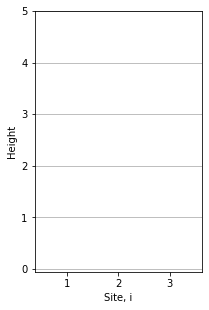

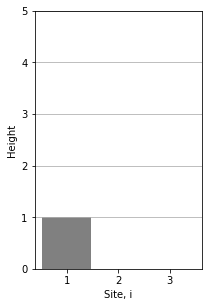

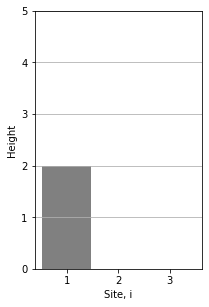

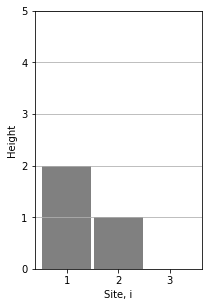

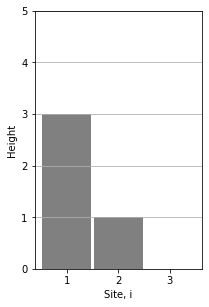

In [321]:
test_model = Model(3)

for i in range(5):
    test_model.plot(clear_screen=False)
    test_model.cycle()

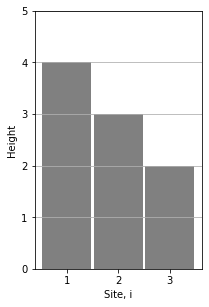

In [322]:
# a quick and easy animation implementation
sleep_amount = 0.5

test_model = Model(3)

for i in range(10):
    test_model.plot(sleep_amount)
    test_model.cycle()

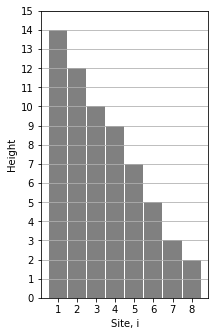

In [318]:
# plotting a larger system at steady state

test_model = Model(8)

while test_model.is_transient:
    test_model.cycle()
test_model.plot()

#### Testing the initialised state

In [492]:
model = Model(3)
print("Length:", model.get_length(), "Expected: 3")
print("Heights:", model.get_all_heights(), "Expected: [0, 0, 0]")
print("Gradients:", model.get_gradients(), "Expected: [0, 0, 0]")
print("Thresholds:", model.get_thresholds(), "Expected: [1|2, 1|2, 1|2]")
print("Pile height:", model.get_pile_height(), "Expected: 0")

Length: 3 Expected: 3
Heights: [0, 0, 0] Expected: [0, 0, 0]
Gradients: [0, 0, 0] Expected: [0, 0, 0]
Thresholds: [1, 1, 2] Expected: [1|2, 1|2, 1|2]
Pile height: 0 Expected: 0


#### Testing the model after one cycle

In [493]:
model = Model(3)
model.cycle()
print("Length:", model.get_length(), "Expected: 3")
print("Heights:", model.get_all_heights(), "Expected: [1, 0, 0]")
print("Gradients:", model.get_gradients(), "Expected: [1, 0, 0]")
print("Thresholds:", model.get_thresholds(), "Expected: [1|2, 1|2, 1|2]")
print("Pile height:", model.get_pile_height(), "Expected: 1")

Length: 3 Expected: 3
Heights: [1, 0, 0] Expected: [1, 0, 0]
Gradients: [1, 0, 0] Expected: [1, 0, 0]
Thresholds: [1, 1, 1] Expected: [1|2, 1|2, 1|2]
Pile height: 1 Expected: 1


#### Testing the initial distribution of thresholds

This should be 1/2 1 and 1/2 2

In [494]:
size = 1000000
model = Model(size)
thresholds = model.get_thresholds()
ones = sum([i == 1 for i in thresholds])
twos = sum([i == 2 for i in thresholds])
print("System size:", size)
print("Ones:", ones, "Twos:", twos)
print("Fraction of ones:", ones / size)
print("Fraction of twos:", twos / size)

System size: 1000000
Ones: 500255 Twos: 499745
Fraction of ones: 0.500255
Fraction of twos: 0.499745


#### Testing that the transient phase increases with system length

It does, and gives sensible values

In [8]:
# measuring transient phase for L16
test_model = Model(4)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

17


In [9]:
# measuring transient phase for L16
test_model = Model(16)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

229


In [10]:
# measuring transient phase for L32
test_model = Model(32)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

882


#### Testing the average gradient in steady state

This should be between one and two, which it is

In [12]:
model = Model(128)
while model.is_transient:
    model.cycle()
for i in range(10000):
    model.cycle
print(np.average(model.gradients))

1.671875


### Suggested Tests from the Lab Manual

In [495]:
# L16 model should have average height of 26.5

final_heights = []

test_model = Model(16)
# get to steady state
while test_model.get_is_transient():
    test_model.cycle()
# once in steady state run for a set number of trials
for i in range(100000):
    test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print("Expected: 26.5, measured: %.2f" % np.average(final_heights))

Expected: 26.5, measured: 26.53


In [496]:
# L32 model should have average height of 53.9

final_heights = []

test_model = Model(32)
# get to steady state
while test_model.get_is_transient():
    test_model.cycle()
# once in steady state run for a set number of trials
for i in range(10000):
    test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print("Expected: 53.9, measured: %.2f" % np.average(final_heights))

Expected: 53.9, measured: 53.86


# 2a) Height of the Pile

In [855]:
# measuring transient phase for L512, seems to be 50-60k cycles
# since this determines the total number of cycles to run
test_model = Model(512)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

226137


In [857]:
lengths = [4, 8, 16, 32, 64, 128, 256, 512]
number_cycles = 250000
filename = 'heights.pickle'

In [858]:
heights: list[list[int]] = []
for length in lengths:
    output = []
    model = Model(length)
    for i in range(number_cycles):
        model.cycle()
        output.append(model.get_pile_height())
    heights.append(output)
    print(length, 'complete')

# saving
with open(filename, "wb") as f:
  pickle.dump(heights, f)

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete
512 complete


In [ ]:
# reload saved
with open(filename, "rb") as f:
  heights = pickle.load(f)

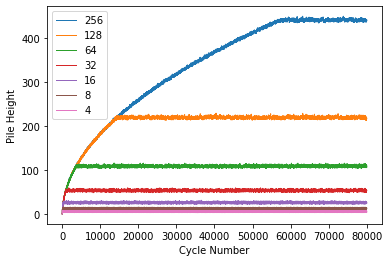

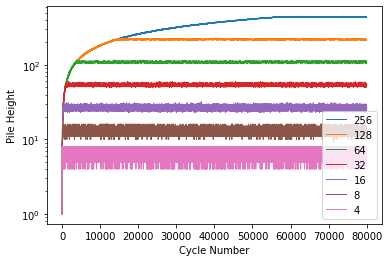

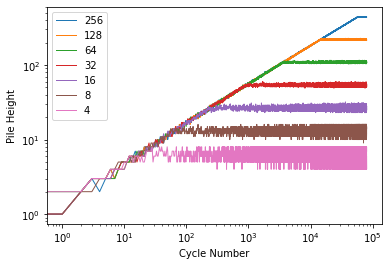

In [48]:
# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.show()

# log linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.yscale("log")
plt.show()

# log log plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.xscale("log")
plt.yscale("log")
plt.show()

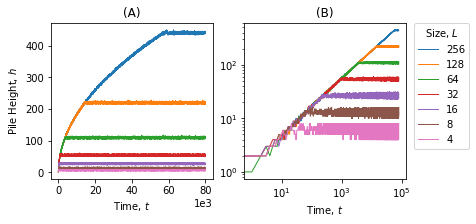

In [377]:
# plot for the paper

fig = plt.figure(figsize=(6.5, 3), layout="constrained")

# linear plot
ax1 = fig.add_subplot(121)
for i in reversed(range(len(lengths))):
    ax1.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
# ax1.legend()
ax1.set_xlabel("Time, $t$")
ax1.set_ylabel("Pile Height, $h$")
ax1.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
ax1.set_title("(A)")

# log log plot
ax2 = fig.add_subplot(122)
for i in reversed(range(len(lengths))):
    ax2.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0., title="Size, $L$", markerscale=20)
ax2.set_xlabel("Time, $t$")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("(B)")

plt.savefig('height_with_time.svg', format='svg', bbox_inches='tight')

# 2b) Cross Over Times

In [849]:
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 10  # could increase this later

In [357]:
cross_over_times = []
for length in lengths:
    times = []
    for i in range(repetitions):
        model = Model(length)
        # if a grain exits on the first cycle, counter should be 0
        # since we are measuring total grains *before* an exit
        counter = -1
        while model.get_is_transient():
            model.cycle()
            counter += 1
        times.append(counter)
    cross_over_times.append(np.average(times))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


Fit: 0.85 * x^2


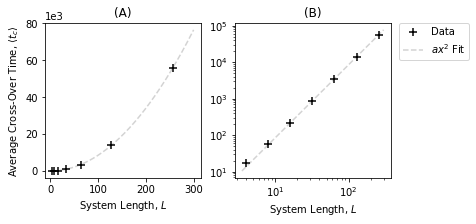

In [850]:
def squared_func(x, a):
    return a*x**2


popt, pcov = curve_fit(squared_func, lengths, cross_over_times)
fit_x_vals = np.linspace(3.5, 300, 1000)
fit_y_vals = squared_func(fit_x_vals, *popt)
print("Fit: %.2f * x^2" % popt[0])

# plot
fig = plt.figure(figsize=(6.5, 3), layout="constrained")

# linear plot
ax1 = fig.add_subplot(121)
ax1.scatter(lengths, cross_over_times, s=50,
            marker="+", c="k", label="Data")  # type: ignore
ax1.plot(fit_x_vals, fit_y_vals, label=r"$ax^2$ Fit",
         color='lightgrey', linestyle='dashed', zorder=-1)
# ax1.legend()
ax1.set_xlabel("System Length, $L$")
ax1.set_ylabel(r"Average Cross-Over Time, $\langle t_c \rangle$")
ax1.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
ax1.set_title("(A)")

# log-log plot
ax2 = fig.add_subplot(122)
ax2.scatter(lengths, cross_over_times, s=50,
            marker="+", c="k", label="Data")  # type: ignore
ax2.plot(fit_x_vals, fit_y_vals, label=r"$ax^2$ Fit",
         color='lightgrey', linestyle='dashed', zorder=-1)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0.)
ax2.set_xlabel("System Length, $L$")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("(B)")

plt.savefig('cross_over_times.svg', format='svg', bbox_inches='tight')

# 2c) Scaling Arguments

Notes from Kim: have to be very careful with your assumptions, but for very large systems the system will tend towards a fixed gradient, with deviations from it, and this scale as a large triangle is along the right lines. 

For a system length far larger than 1, there will be some consistent value for the average gradient. This is not necessarily the average of the two possible threshold gradients, since the gradient can be less than the threshold gradient, and thus a site with threshold two is less likely to become super critical, either form the addition of blocks from the left or the removal of blocks from the right.

In [9]:
def get_average_gradient(size):
    steady_state_cycles = 10000
    repetitions = 5
    averages = []
    heights = []
    for i in range(repetitions):
        model = Model(size)
        while model.is_transient:
            model.cycle()
        for i in range(steady_state_cycles):
            model.cycle()
        averages.append(np.average(model.gradients))
        heights.append(model.get_pile_height())
    print("Size: %i, Average of Gradients: %.3f, Height over Length: %.3f" %
          (size, np.average(averages), np.average(heights)/size))


get_average_gradient(16)
get_average_gradient(32)
get_average_gradient(64)
get_average_gradient(128)
get_average_gradient(256)

Size: 16, Average of Gradients: 1.688, Height over Length: 1.688
Size: 32, Average of Gradients: 1.688, Height over Length: 1.688
Size: 64, Average of Gradients: 1.700, Height over Length: 1.700
Size: 128, Average of Gradients: 1.717, Height over Length: 1.717
Size: 256, Average of Gradients: 1.715, Height over Length: 1.715


Empirically the average value is found to be about 1.7, however all that matters is that this average gradient is scale independent on large scales. Given a set gradient, this gives systems of a sufficiently large width a triangular form, even in the transient phase, with angles that do not change with scale for all sufficiently large numbers. 

**Conclusion**

This gives the height of the triangle to be directly proportional to the base of the triangle, i.e. the length of the system. Similarly, cross over time corresponds to the area of the triangle, and thus cross over time should scale with square of the system length.

# Side Investigation Into Average Gradient

Note: point of this should be to validate the assumption that there is a fixed gradient for systems much larger than 1, since extensions are not given many marks if any.

As shown above, we can simply take the height of the pile, and divide it by the width of the pile to get the average gradient.

This means that repeating the average height time series above, can allow us to visually conclude whether the average gradient is indeed dependent on system size. Note that during the transient, this relation breaks down since the base of the pile has not reached the width of the system, so we will ignore any sites with height $0$. 

### Investigating Average Slope for the BTK Model 

I.e. setting all thresholds to 1

In [135]:
slopes: list[list[int]] = []
widths: list[list[int]] = []
heights: list[list[int]] = []
lengths = [32, 64, 128, 256]
number_cycles = 10000
repetitions = 20
prob_of_2 = 0

In [136]:
for length in lengths:
    all_slopes = []
    all_widths = []
    all_heights = []
    for _ in range(repetitions):
        output_slopes = []
        output_widths = []
        output_heights = []
        model = Model(length, prob_of_2)
        for i in range(number_cycles):
            model.cycle()
            width = model.get_pile_width()
            height = model.get_pile_height()
            output_slopes.append(height / width)
            output_widths.append(width)
            output_heights.append(height)
        all_slopes.append(output_slopes)
        all_widths.append(output_widths)
        all_heights.append(output_heights)
    slopes.append(average_different_lengths(all_slopes))
    widths.append(average_different_lengths(all_widths))
    heights.append(average_different_lengths(all_heights))
    print(length, 'complete')

32 complete
64 complete
128 complete
256 complete


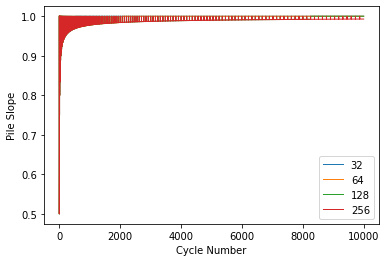

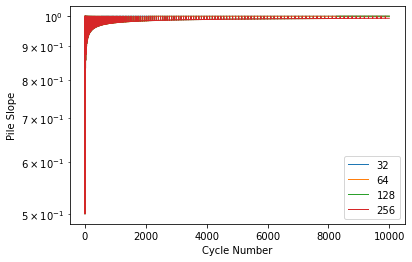

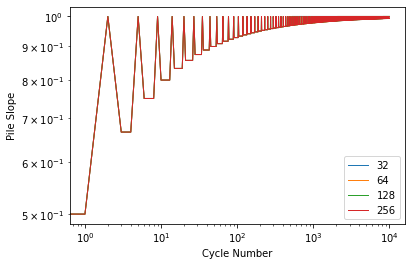

In [137]:
# linear plot
for i in range(len(lengths)):
    plt.plot(range(number_cycles), slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Slope")
plt.show()

# log linear plot
for i in range(len(lengths)):
    plt.plot(range(number_cycles), slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Slope")
plt.yscale("log")
plt.show()

# log log plot
for i in range(len(lengths)):
    plt.plot(range(number_cycles), slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Slope")
plt.xscale("log")
plt.yscale("log")
plt.show()

Plotting the data against pile width

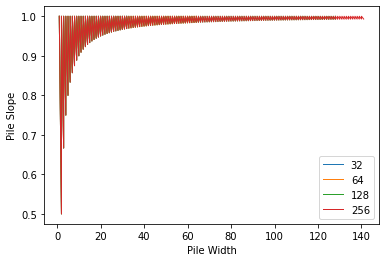

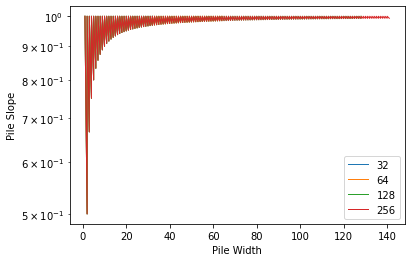

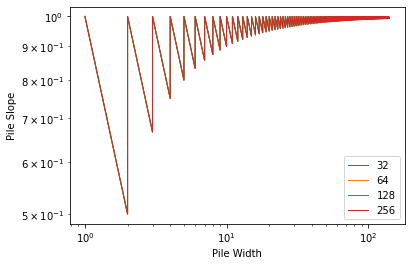

In [138]:
# linear plot
for i in range(len(lengths)):
    plt.plot(widths[i], slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Pile Width")
plt.ylabel("Pile Slope")
plt.show()

# log linear plot
for i in range(len(lengths)):
    plt.plot(widths[i], slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Pile Width")
plt.ylabel("Pile Slope")
plt.yscale("log")
plt.show()

# log log plot
for i in range(len(lengths)):
    plt.plot(widths[i], slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Pile Width")
plt.ylabel("Pile Slope")
plt.xscale("log")
plt.yscale("log")
plt.show()

### Repeating these same graphs for the Oslo Model

In [149]:
slopes: list[list[int]] = []
widths: list[list[int]] = []
heights: list[list[int]] = []
lengths = [32, 64, 128, 256]
number_cycles = 40000
repetitions = 1
prob_of_2 = 0.5  # the default value

In [150]:
for length in lengths:
    all_slopes = []
    all_widths = []
    all_heights = []
    for _ in range(repetitions):
        output_slopes = []
        output_widths = []
        output_heights = []
        model = Model(length, prob_of_2)
        for i in range(number_cycles):
            model.cycle()
            width = model.get_pile_width()
            height = model.get_pile_height()
            output_slopes.append(height / width)
            output_widths.append(width)
            output_heights.append(height)
        all_slopes.append(output_slopes)
        all_widths.append(output_widths)
        all_heights.append(output_heights)
    slopes.append(average_different_lengths(all_slopes))
    widths.append(average_different_lengths(all_widths))
    heights.append(average_different_lengths(all_heights))
    print(length, 'complete')

32 complete
64 complete
128 complete
256 complete


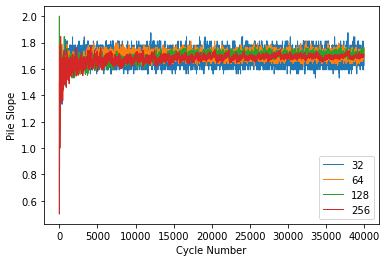

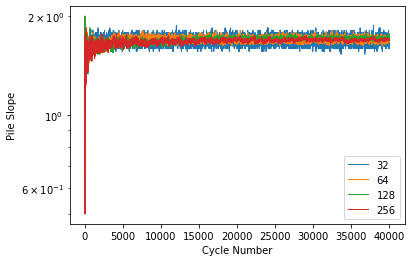

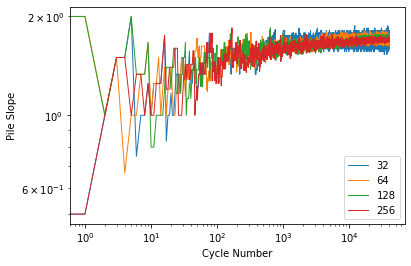

In [151]:
# linear plot
for i in range(len(lengths)):
    plt.plot(range(number_cycles), slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Slope")
plt.show()

# log linear plot
for i in range(len(lengths)):
    plt.plot(range(number_cycles), slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Slope")
plt.yscale("log")
plt.show()

# log log plot
for i in range(len(lengths)):
    plt.plot(range(number_cycles), slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Slope")
plt.xscale("log")
plt.yscale("log")
plt.show()

Plotting the data against pile width

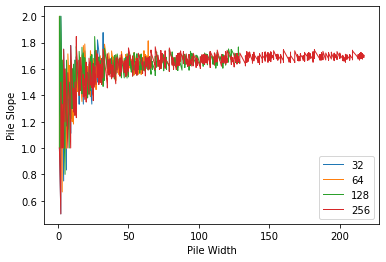

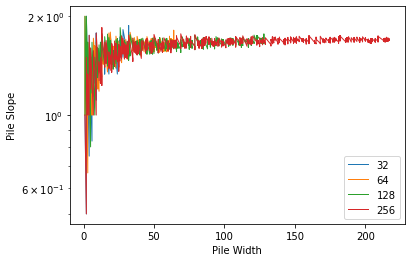

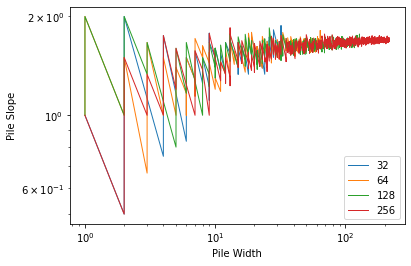

In [152]:
# linear plot
for i in range(len(lengths)):
    plt.plot(widths[i], slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Pile Width")
plt.ylabel("Pile Slope")
plt.show()

# log linear plot
for i in range(len(lengths)):
    plt.plot(widths[i], slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Pile Width")
plt.ylabel("Pile Slope")
plt.yscale("log")
plt.show()

# log log plot
for i in range(len(lengths)):
    plt.plot(widths[i], slopes[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Pile Width")
plt.ylabel("Pile Slope")
plt.xscale("log")
plt.yscale("log")
plt.show()

This means we have an answer as to why our initial values appeared to increase with system length. If we consider the BKT model, there is an upper limit on the gradient, meaning fluctuations are not Gaussian around a mean, but asymmetrical since fluctuations can only be smaller than the asymptotic value. This effect is greater for smaller system sizes, and analogously smaller pile widths, and average gradient does indeed increase with system size asymptotically.

This means we can indeed assume a system independent value of the average gradient, if we ignore the effects from the system being finite with discrete sites.

### Why is the infinite system average gradient not 1.5

The reason the average gradient is not 1.5 is because sites with threshold 1 are more likely to topple than those with threshold 2. This means there is a probability of sites of threshold 1 toppling and having a threshold of 1 again, a probability they'll go from 1 to 2, 2 to 2 and 2 to 1. This can then be represented with a two state Markov graph.

In [485]:
# cycle_with_threshold_transition_counts

counts = {
    1: Counter({
        1: 0,
        2: 0
    }),
    2: Counter({
        1: 0,
        2: 0
    })
}
model_size = 64
repetitions = 1
cycles = 100000

for i in range(repetitions):
    model = Model(model_size)
    while model.is_transient:
        model.cycle()
    for i in range(cycles):
        new_counts = model.cycle_with_threshold_transition_counts()
        for i in counts.keys():
            counts[i].update(new_counts[i])

print(counts)

{1: Counter({2: 1599068, 1: 1598875}), 2: Counter({1: 1599069, 2: 1598605})}


In [5]:
total_transitions = 0
for i in counts.keys():
    for j in counts[i].keys():
        total_transitions += counts[i][j]
print("Total transitions measured:", total_transitions)

for i in counts.keys():
    for j in counts[i].keys():
        print("%d to %d: %.6f" % (i, j, counts[i][j] / total_transitions))

Total transitions mesaured: 6396942
1 to 1: 0.249551
1 to 2: 0.250188
2 to 1: 0.250188
2 to 2: 0.250074



### Average gradient with system size

After realising my theoretical argument is based on an average gradient that doesn't vary with system size, I tried to test it only to find it does indeed increase with system size! Not sure why this is happening, whether there's a bias in my sampling of average gradient or whether there's something more interesting going on.

If even numbers of sites had threshold 1 and 2, and both were at the maximum gradients, i.e. all the threshold 1 sites had gradient 1 and all the threshold 2 sites had gradient 2, then the maximum possible average gradient could only be 1.5

However, we're seeing a gradient even greater than that of around 1.7, so there must be more sites with threshold 2 than 1, and so we should see more transitions to threshold 2 than back to threshold 1. 

In [489]:
# cycle_with_threshold_transition_counts

counts = ({
    1: Counter({
        1: 0,
        2: 0
    }),
    2: Counter({
        1: 0,
        2: 0
    })
})
thresholds: list[int] = []
model_size = 64
repetitions = 10
cycles = 1000

for rep in range(repetitions):
    model = Model(model_size, p=0.5)
    while model.is_transient:
        model.cycle()
    for _ in range(cycles):
        new_counts = model.cycle_with_threshold_transition_counts()
        for i in counts.keys():
            counts[i].update(new_counts[i])
    thresholds += model.get_thresholds()
    print("Rep", rep, "complete")

Rep 0 complete
Rep 1 complete
Rep 2 complete
Rep 3 complete
Rep 4 complete
Rep 5 complete
Rep 6 complete
Rep 7 complete
Rep 8 complete
Rep 9 complete


In [490]:
total_transitions = {1: 0, 2: 0}
for i in counts.keys():
    for j in counts[i].keys():
        total_transitions[i] += counts[i][j]

print("Total transitions measured:", sum(total_transitions.values()))

print("Total Counts:")
for i in counts.keys():
    for j in counts[i].keys():
        print("%d to %d: %i" % (i, j, counts[i][j]))

print("Fractional Counts:")
for i in counts.keys():
    for j in counts[i].keys():
        print("%d to %d: %.6f" % (i, j, counts[i][j] / total_transitions[i]))

print("Threshold distribution:")
print("1: %.3f" % (sum([i == 1 for i in thresholds]) / len(thresholds)))
print("2: %.3f" % (sum([i == 2 for i in thresholds]) / len(thresholds)))

Total transitions measured: 575334
Total Counts:
1 to 1: 143813
1 to 2: 143556
2 to 1: 143531
2 to 2: 144434
Fractional Counts:
1 to 1: 0.500447
1 to 2: 0.499553
2 to 1: 0.498432
2 to 2: 0.501568
Threshold distribution:
1: 0.131
2: 0.869


These are the same since we are only looking at sites that topple - every site that topples reassigns its threshold so we might expect them to be the same. So it must be that despite an even number of 1 and 2 thresholds sites toppling, there must be many more threshold 2 sites that never topple in the first place...

These values are only for sites which are supercritical, so in essence it is confirming that in steady state an even number of sites change from 1 to 2 as do from 2 to 1. Since the probabilities of 1 to 2 and 1 to 1 are hard coded to be the same, it is to be expected that all four values are identical. 

I am not quite sure why 1 to 1 seems to have a very small deviation away compared to the others, and this seems to be robust even for large sample sizes. 

If we now take into account any potential relaxations, and then add those that don't relax as self mapping, i.e. 1 to 1 and 2 to 2, then we can investigate the robustness of the different thresholds. 

Each site has the potential to relax when a site adjacent to it has relaxed. Therefore transitions are now counted when 

1) The site has relaxed
2) An adjacent site has relaxed, but that site hasn't relaxed

The second condition is important to only count the sites that aren't supercritical, otherwise supercritical sites will be counted twice

In [373]:
counts = {
    1: Counter({
        1: 0,
        2: 0
    }),
    2: Counter({
        1: 0,
        2: 0
    })
}
model_size = 64
repetitions = 10
cycles = 10000

for i in range(repetitions):
    model = Model(model_size)
    while model.is_transient:
        model.cycle()
    for i in range(cycles):
        new_counts = model.cycle_with_possible_threshold_transition_counts()
        for i in counts.keys():
            counts[i].update(new_counts[i])

print(counts)

Counter({1: Counter({1: 2854997, 2: 1586727}), 2: Counter({2: 5713641, 1: 1586705})})


In [374]:
total_transitions = {1: 0, 2: 0}
for i in counts.keys():
    for j in counts[i].keys():
        total_transitions[i] += counts[i][j]

print("Total transitions measured:", sum(total_transitions.values()))

print("Total Counts:")
for i in counts.keys():
    for j in counts[i].keys():
        print("%d to %d: %i" % (i, j, counts[i][j]))

print("Fractional Counts:")
for i in counts.keys():
    for j in counts[i].keys():
        print("%d to %d: %.6f" % (i, j, counts[i][j] / total_transitions[i]))

print("Threshold distribution:")
print("1: %.3f" % (sum([i == 1 for i in thresholds]) / len(thresholds)))
print("2: %.3f" % (sum([i == 2 for i in thresholds]) / len(thresholds)))

Total transitions measured: 11742070
Total Counts:
1 to 1: 2854997
1 to 2: 1586727
2 to 1: 1586705
2 to 2: 5713641
Fractional Counts:
1 to 1: 0.642768
1 to 2: 0.357232
2 to 1: 0.217347
2 to 2: 0.782653
Threshold distribution:
1: 0.141
2: 0.859


In [ ]:
# probability of threshold 1 site changing to threshold 2
0.135 / (0.135 + 0.243)

0.35714285714285715

In [ ]:
# probability of threshold 2 site changing to threshold 1
0.135 / (0.486 + 0.135)

0.2173913043478261

In [ ]:
# percentage flux of threshold 1 to 2
0.357 * 0.141

0.05033699999999999

In [ ]:
# percentage flux of threshold 2 to 1
0.135 * 0.859

0.11596500000000001

Can indeed see that it's less likely for a threshold 2 site to collapse than a threshold 1 site. 

I was expecting the relative fraction of sites in threshold 1 times chance of threshold 1 to 2 to be equal to number in 2 times prob 2 to 1, but this isn't the case. Perhaps this indicates that I'm still missing a type of 1to1 and 2to2 type scenario.

--- 
Note to self, considering the data these are coming from are the explicit fluxes, and that they match, this is clearly an error in my maths for trying to relate the fluxes to the probabilities - even though the probabilities I'm using are themselves derived from the balancing fluxes!!

### Measuring System State Distribution

More interesting might be measuring the distribution of states in the system for a large model in steady state. This means measuring the threshold, and also the gradients for each site, and finding the distribution.

In [310]:
repetitions = 100
cycles = 1000
model_size = 128

# first key is the threshold, second key is the gradient
counts: dict[int, dict[int, int]] = {
    1: {
        0: 0,
        1: 0,
        2: 0
    },
    2: {
        0: 0,
        1: 0,
        2: 0
    }
}

for i in range(repetitions):
    model = Model(model_size, p=0.5)
    while model.is_transient:
        model.cycle()
    for _ in range(cycles):
        model.cycle()
    gradients = model.get_gradients()
    thresholds = model.get_thresholds()
    for n in range(model_size):
        counts[thresholds[n]][gradients[n]] += 1

In [312]:
total_transitions = 0
for i in counts.keys():
    for j in counts[i].keys():
        total_transitions += counts[i][j]
print("Total transitions mesaured:", total_transitions)

for i in counts.keys():
    print("Threshold:", i)
    for j in counts[i].keys():
        print("  Gradient: %i = %.3f" % (j, counts[i][j]/total_transitions))

Total transitions mesaured: 12800
Threshold: 1
  Gradient: 0 = 0.007
  Gradient: 1 = 0.124
  Gradient: 2 = 0.000
Threshold: 2
  Gradient: 0 = 0.008
  Gradient: 1 = 0.133
  Gradient: 2 = 0.728


In [301]:
# Can check these agree with the average gradient, of around 1.7
0.13 * 2 + 0.73 * 2

1.72

Interestingly the 2:2 fraction is enormous, which is why the gradient is so large, as expected. The 1:0 and 2:0 fractions are much smaller than I was expecting, but they are the same, as are the 1:1 and 2:1 fractions.

### State Transition Probabilities

Next, let's find the transition probabilities of which states transition to which other states. This should then allow us to see if our simple model was along the right lines or not.
A given state can transition to any given other state, including itself. A transition in this model is a relaxation, i.e. something happening to that site. This means that the threshold can obviously map to itself, but the gradient will not, for example. These are then normalised for each starting state, to give the probabilities.

I tried to do this but quickly ran into a problem - since the Oslo model can have enormous avalanches, and my model implements the relaxing by working from left to right, by the time it's moved the enormous avalanche far to the right then the gradients become enormous. This means the whole concept of measuring state transitions is a waste of time, since we map states from stable to stable, which are incredibly difficult for enormous avalanches, or we include the infinite number of unstable state transitions, which are also impossible to analyse analytically. Therefore this is a waste of time, but very interesting. 

# 2d) Data Collapse of Average Height Scaling

In [834]:
# lengths = [4, 8, 16, 32, 64, 128, 256]
lengths = [16, 32, 64, 128, 256]
repetitions = 5  # could increase this later

In [347]:
average_heights_with_time: list[list[int]] = []
for length in lengths:
    height_lists: list[list[int]] = []
    for i in range(repetitions):
        model = Model(length)
        height_values: list[int] = []
        while model.get_is_transient():
            model.cycle()
            height_values.append(model.get_pile_height())
        # continue for 1/2 L^2 more cycles
        for i in range(int(0.5*length**2)):
            model.cycle()
            height_values.append(model.get_pile_height())
        height_lists.append(height_values)
    average_heights_with_time.append(average_different_lengths(height_lists))
    print(length, 'complete')

16 complete
32 complete
64 complete
128 complete
256 complete


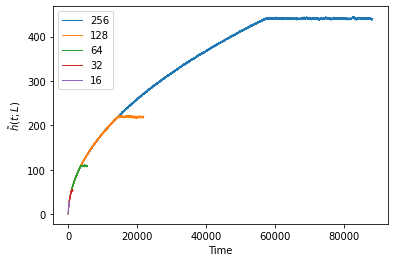

In [348]:
# poly_fit = np.polyfit(lengths, average_heights, 1)
# fit_x_vals = np.linspace(0, 300, 100)
# fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
# plt.plot(fit_x_vals, fit_y_vals, label='1st Order Polynomial Fit')

for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_heights_with_time[i])), average_heights_with_time[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Time")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

The form of the data collapse has to be:

$\text{F: } \tilde{h}(t;L) = x_1 \text{F}(x_2)$

Considering we have a theoretical argument that steady state height scales with system length $L$, we hypothesise that $x_1 = L$

Which should lead to all the peaks reaching the same maximum height when we plot:

$\frac{\tilde{h}(t;L)}{L} = \text{F}(x_2)$

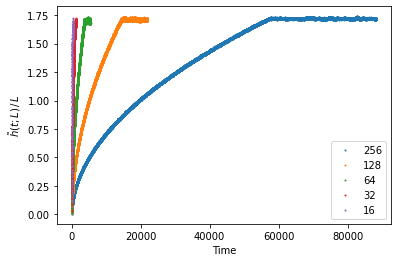

In [349]:
y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [list(range(len(i))) for i in average_heights_with_time]

# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

for i in reversed(range(len(lengths))):
    plt.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1)
plt.legend()
plt.xlabel("Time")
plt.ylabel(r"$\tilde{h}(t;L) \, / \, L$")
plt.show()

This looks correct, meaning $x_1 = L$ as predicted.

Horizontally, the data still hasn't collapsed though, meaning that there is another scaling in the argument of F. This can be seen to be the crossover time, which we have argued should be proportional to the square of the system length. Thus we predict that $x_2 = t/L^2$. Plotting $t/L^2$ on the x axis rather than $t$ should therefore lead to the desired data collapse:

$\frac{\tilde{h}(t;L)}{L} = \text{F}(\frac{t}{L^2})$

Text(0.5, 1.0, '(B)')

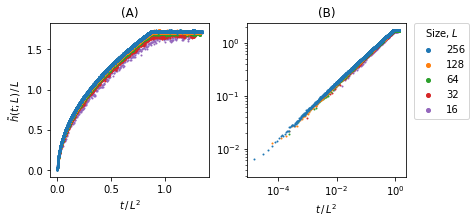

In [835]:
y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [np.array(range(len(average_heights_with_time[i])))/(lengths[i]**2)
          for i in range(len(average_heights_with_time))]

# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

# plotting
fig = plt.figure(figsize=(6.5, 3), layout="constrained")

# linear
ax1 = fig.add_subplot(121)
for i in range(len(lengths)):
    ax1.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1, c="C%i" % (len(lengths) - i - 1))
ax1.set_xlabel(r"$t \, / \, L^2$")
ax1.set_ylabel(r"$\tilde{h}(t;L) \, / \, L$")
ax1.set_title("(A)")

# logarithmic
ax2 = fig.add_subplot(122)
for i in range(len(lengths)):
    ax2.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1, c="C%i" % (len(lengths) - i - 1))
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(reversed(handles), reversed(labels), bbox_to_anchor=(
    1.05, 1), loc='upper left', borderaxespad=0., title="Size, $L$", markerscale=4)
ax2.set_xlabel(r"$t \, / \, L^2$")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("(B)")

# plt.savefig('data_collapse.svg', format='svg', bbox_inches='tight')

Which does indeed seem to give us a data collapse! 

Since this is a graph of the scaling function, we can see that for $x>>1$ it becomes constant, and for $x<<1$ it tends to 0. 

### Behaviour during the transient

Given that our theoretical predictions of treating the system as a large triangle seem to have been validated, this would lead us to conclude that pile height during the transient phase is proportional to the square root of the area, which itself is given by the time:

$\tilde{h}(t;L) \propto{} t^{1/2}$

We can verify this simply:

In [32]:
average_height_sequences = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 5

In [33]:
for length in lengths:
    heights = []
    for i in range(repetitions):
        model = Model(length)
        values = []
        while model.get_is_transient():
            model.cycle()
            values.append(model.get_pile_height())
        heights.append(values)
    average_height_sequences.append(average_different_lengths(heights))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


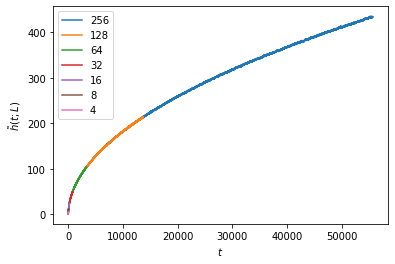

In [34]:
# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

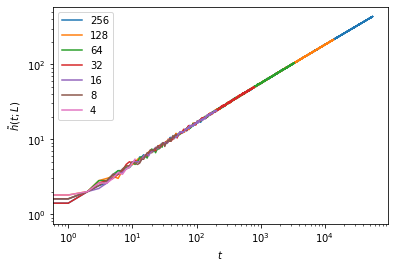

In [35]:
# log-log plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

Fit found to be: y = 1.837 t^0.5


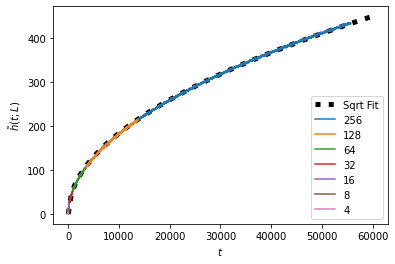

In [36]:
# fit the sqrt function to the data
def sqrt_func(x, a0):
    return a0 * np.sqrt(x)

popt, pcov = curve_fit(sqrt_func, range(
    len(average_height_sequences[-1])), average_height_sequences[-1])
print("Fit found to be: y = %.3f t^0.5" % popt[0])
fit_x_vals = np.linspace(0, 60000, 100)
fit_y_vals = sqrt_func(fit_x_vals, popt)
plt.plot(fit_x_vals, fit_y_vals, label='Sqrt Fit',
         linestyle='dotted', c='k', linewidth=5)

# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

Given we are now confident that:

$\tilde{h}(t;L) = k t^{1/2}$,

### Bonus, extending this back to the scaling function

where $k$ is some constant, holds, we know that during the transient:

$\tilde{h}(t;L) = k t^{1/2}  = L\text{F}(\frac{t}{L^2})$

and so, during the transient:

$\mathcal{F}(\frac{t}{L^2}) = \frac{k}{L}t^{1/2} = k(\frac{t}{L^2})^{1/2}$

We can plot the scaling function for only the transient period and then curve fit to see whether this holds:

In [37]:
average_heights_with_time: list[list[int]] = []
# lengths = [4, 8, 16, 32, 64, 128, 256]
lengths = [16, 32, 64, 128, 256]
repetitions = 5  # could increase this later

In [38]:
for length in lengths:
    height_lists: list[list[int]] = []
    for i in range(repetitions):
        model = Model(length)
        height_values: list[int] = []
        while model.get_is_transient():
            model.cycle()
            height_values.append(model.get_pile_height())
        height_lists.append(height_values)
    average_heights_with_time.append(average_different_lengths(height_lists))
    print(length, 'complete')

16 complete
32 complete
64 complete
128 complete
256 complete


Fit found to be: y = 1.837 t^0.5


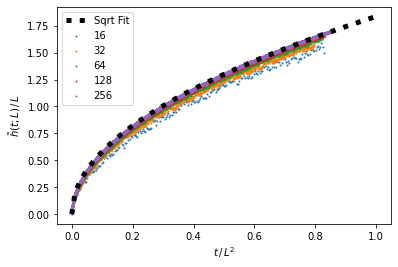

In [41]:
# fitting the 256 data
popt, pcov = curve_fit(sqrt_func, range(
    len(average_height_sequences[-1])), average_height_sequences[-1])
print("Fit found to be: y = %.3f t^0.5" % popt[0])
fit_x_vals = np.linspace(0, 1, 100)
fit_y_vals = sqrt_func(fit_x_vals, popt)
plt.plot(fit_x_vals, fit_y_vals, label='Sqrt Fit',
         linestyle='dotted', c='k', linewidth=5)

y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [np.array(range(len(average_heights_with_time[i])))/(lengths[i]**2)
          for i in range(len(average_heights_with_time))]

# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

for i in range(len(lengths)):
    plt.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1)
plt.legend()
plt.xlabel(r"$t \, / \, L^2$")
plt.ylabel(r"$\tilde{h}(t;L) \, / \, L$")
plt.show()

This also confirms our prediction that both would share the same value for $k$ which is found to be 1.837 for both fits. 

### Extension: Steady State and the Full Function

To complete our equations for the scaling function, we consider the behaviour in the steady state. 

If we considered an alternative setup where the average gradient was exactly 1, then we would expect the grain pile to form a triangle with height equal to it's base length. The area of this triangle would be $t$, since 1 grain is added to the pile per time interval. This would give the area of the triangle to be: 
$$t = \frac{1}{2}\tilde{h}(t;L)^2$$

therefore:
$$\begin{align}
\tilde{h}(t;L) &= \sqrt{2t} \\
&= \sqrt{2} t^{1/2}
\end{align}$$

If we now introduce an average gradient of $g$, then we find:
$$\begin{align}
t &= \frac{1}{2} \, \frac{\tilde{h}(t;L)^2}{g} \\
\tilde{h}(t;L) &= \sqrt{2gt} \\
&= \sqrt{2g} \, t^{1/2}
\end{align}$$

Meaning that:
$$\begin{align}
k &= \sqrt{2g} \\
g &= \frac{1}{2}k^2
\end{align}$$

In [839]:
# reversing this from the a0 value found later for the asymptotic gradient:
g = 1.74
k = np.sqrt(2 * g)
print(k)

1.865475810617763


In [45]:
0.5 * 1.837**2

1.6872844999999999

Which does roughly match our explicit calculation from earlier, which found the average gradient to be $\approx 1.65$

Given this, we can now predict the steady state height to be simply the average gradient multiplied by the length of the system:
$$\begin{align}
\tilde{h}(t;L) &= gL = \frac{1}{2} k^2 L \\
\frac{\tilde{h}(t;L)}{L} &= g = \frac{1}{2} k^2 \\
\end{align}$$

But when does the data collapsed scaling function transition from the transient to steady state? 

One method would be simply to find the value of the transient function when it reaches our predicted steady state value, but we can instead reason what it should be from 

This will be when the base of the triangle reaches the system size. Since we have established $g$ as the average gradient, we know that the crossover time $t_c$ is given by:
$$t_{c} = \frac{1}{2} \cdot \text{width} \cdot \tilde{h} = \frac{1}{2} g L^2$$

as the scaling function is plotted against $t/L^2$:
$$\frac{t_c}{L^2} = \frac{g}{2} = \frac{k^2}{4}$$

This means we can now formulate the entire piecewise scaling function, which we predict to be of the form:
$$\mathcal{F}(t/L^2) = 
\left\{
    \begin{align}
        &k (t/L^2)^{1/2} &\text{for } t/L^2 < \frac{k^2}{4} \nonumber \\
        &\frac{1}{2}k^2  &\text{for } t/L^2 > \frac{k^2}{4} \nonumber
    \end{align}
\right\}
$$

which we can simplify by substituting $u = t/L^2$ and the average gradient $g = \frac{1}{2}k^2$:
$$\mathcal{F}(u) = 
\left\{
    \begin{align}
        &(2gu)^{1/2} &\text{for } u < \frac{g}{2} \nonumber \\
        &g  &\text{for } u > \frac{g}{2} \nonumber \\
    \end{align}
\right\}
$$

This means the scaling function now has one variable parameter which we can fit to the data, in order to see if this proposed form is correct:

In [57]:
average_heights_with_time: list[list[int]] = []
# lengths = [4, 8, 16, 32, 64, 128, 256]
lengths = [16, 32, 64, 128, 256]
repetitions = 5  # could increase this later
steady_state_cycles = 1000

In [58]:
for length in lengths:
    height_lists: list[list[int]] = []
    for i in range(repetitions):
        model = Model(length)
        height_values: list[int] = []
        while model.get_is_transient():
            model.cycle()
            height_values.append(model.get_pile_height())
        for i in range(steady_state_cycles):
            model.cycle()
            height_values.append(model.get_pile_height())
        height_lists.append(height_values)
    average_heights_with_time.append(average_different_lengths(height_lists))
    print(length, 'complete')

16 complete
32 complete
64 complete
128 complete
256 complete


Fit: g = 1.714


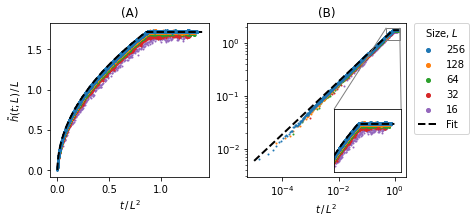

In [847]:
# fit the proposed scaling function
def scaling_func(x, g):
    try:
        x[0]
        results = []
        for x_i in x:
            if x_i < 0.5*g:
                results.append((2*g*x_i) ** 0.5)
            else:
                results.append(g)
        return results
    except:
        if x < 0.5*g:
            return (2*g*x) ** 0.5
        else:
            return g


y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [np.array(range(len(average_heights_with_time[i])))/(lengths[i]**2)
          for i in range(len(average_heights_with_time))]
# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

# fitting
popt, pcov = curve_fit(scaling_func, x_vals[-1], y_vals[-1])
fit_x_vals = np.linspace(0.00001, 1.4, 100000)
fit_y_vals = scaling_func(fit_x_vals, *popt)
print("Fit: g = %.3f" % popt[0])

# plotting
fig = plt.figure(figsize=(6.5, 3), layout="constrained")

# linear
ax1 = fig.add_subplot(121)
ax1.plot(fit_x_vals, fit_y_vals,
         linestyle='dashed', c='k', linewidth=2)
for i in range(len(lengths)):
    ax1.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1, c="C%i" % (len(lengths) - i - 1), rasterized=True)
ax1.set_xlabel(r"$t \, / \, L^2$")
ax1.set_ylabel(r"$\tilde{h}(t;L) \, / \, L$")
ax1.set_title("(A)")

# logarithmic
ax2 = fig.add_subplot(122)
ax2.plot(fit_x_vals, fit_y_vals, label='Fit',
         linestyle='dashed', c='k', linewidth=2)
for i in range(len(lengths)):
    ax2.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1, c="C%i" % (len(lengths) - i - 1), rasterized=True)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(reversed(handles), reversed(labels), bbox_to_anchor=(
    1.05, 1), loc='upper left', borderaxespad=0., title="Size, $L$", markerscale=4)
ax2.set_xlabel(r"$t \, / \, L^2$")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("(B)")

# zoom in
x1 = 0.5
x2 = 1.5
y1 = 1.1
y2 = 1.9

ax2ins = zoomed_inset_axes(ax2, 5, loc=4)
ax2ins.plot(fit_x_vals, fit_y_vals, label='Fit',
            linestyle='dashed', c='k', linewidth=2)
for i in range(len(lengths)):
    ax2ins.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1, c="C%i" % (len(lengths) - i - 1), rasterized=True)
ax2ins.set_xlim(x1, x2)
ax2ins.set_ylim(y1, y2)
ax2ins.set_xticks([])
ax2ins.set_yticks([])
mark_inset(ax2, ax2ins, loc1=2, loc2=1, fc="none", ec="0.5")
plt.draw()

plt.savefig('data_collapse.svg', format='svg', bbox_inches='tight', dpi=300)

Fit to the largest sized system, since we can see from (A) that there are corrections to scaling for the smaller system sizes, since they are lower.

# 2e) Data Generation

Note here we should **not** take averages over repeated runs of the model for each length

In [852]:
lengths = [4, 8, 16, 32, 64, 128, 256, 512]
num_cycles = 100000

In [425]:
height_sequence_list: list[list[int]] = []
for length in lengths:
    height_sequence: list[int] = []
    model = Model(length)
    while model.get_is_transient():
        model.cycle()
    for i in range(num_cycles):
        model.cycle()
        height_sequence.append(model.get_pile_height())
    height_sequence_list.append(height_sequence)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete
512 complete


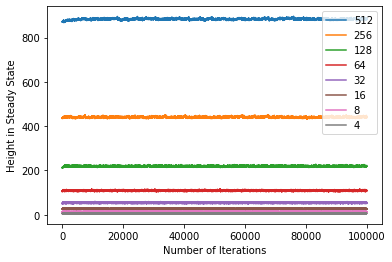

In [426]:
# linear plot of the raw data
for i in reversed(range(len(lengths))):
    plt.plot(range(len(height_sequence_list[i])),
             height_sequence_list[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Height in Steady State")
plt.show()

A sanity check on the first histogram for L=4, as the counts should roughly correspond to the heights on the histogram

In [196]:
# counting frequencies to check the histograms
counts: dict[int, int] = {}
for i in np.sort(height_sequence_list[0]):
    try:
        counts[i] += 1
    except:
        counts[i] = 1
counts

{4: 410, 5: 14180, 6: 45594, 7: 33576, 8: 6240}

# Calculation of Av Height, Std, Height Prob

Length: 4
Average: 6.31167
Std: 0.803
Probability distribution:


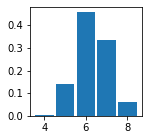

Length: 8
Average: 12.97866
Std: 0.961
Probability distribution:


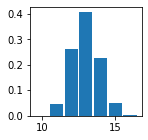

Length: 16
Average: 26.51549
Std: 1.134
Probability distribution:


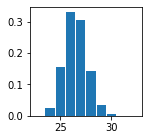

Length: 32
Average: 53.90893
Std: 1.336
Probability distribution:


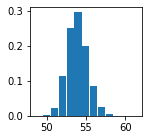

Length: 64
Average: 108.92918
Std: 1.593
Probability distribution:


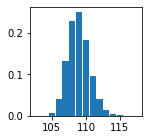

Length: 128
Average: 219.22026
Std: 1.855
Probability distribution:


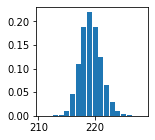

Length: 256
Average: 440.54217
Std: 2.318
Probability distribution:


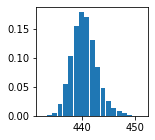

Length: 512
Average: 882.93023
Std: 2.965
Probability distribution:


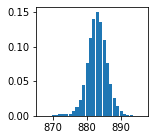

In [427]:
for i in range(len(lengths)):
    data = height_sequence_list[i]
    print("="*10)
    print("Length:", lengths[i])
    average = np.average(data)
    print("Average:", average)
    std = np.std(data)
    print("Std:", "%.3f" % std)
    print("Probability distribution:")
    plt.subplots(figsize=(2, 2))
    plt.hist(data, max(data) - min(data) + 1, density=True,
             rwidth=0.9, range=(min(data)-0.5, max(data)+0.5))
    plt.show()

# 2e) Corrections to Scaling

- Listening into the conversation, a_0 is the infinite limit of the average slope. You cannot directly measure it, but you could fit a function to it and therefore extract the infinite limit, which is what I've already done
- The average slope is the average height over L, which is a_0
- Should investigate logs for both sides of 2e perhaps? Plot against log L
- Might be that you plot a_0 times the data, but that could be wrong
- Should try and make this into a straight line if possible

Note on fitting I heard

- You must always always plot error bars when you are plotting averages
    - Or if they're too small, then write that the error bars are too small to show 
    - Alternatively have a second plot along the side and show the error bars on there

- KS test, QQ plot are both good options for comparing the Gaussians
    - These are good ideas for checking 
    - These give you a measure of how different it is in a statistical sense, rather than just spitting out a 
    - So they'll give you a sigma value
- Parametric and non parametric statistical tests 
    - So chi squared is a non parametric test which is better than a parametric test where you are just fitting parameters

- Tried adding a QQ plot but it will need a little more work given we're using scaled data and I'm not sure how to squeeze that into a QQ function
    - Will leave this for now

Plotting the average heights against system size, we find:

In [428]:
# calculate the averages
average_height_list: list = []
for l in height_sequence_list:
    average_height_list.append(np.average(l))
print(average_height_list)

[6.31167, 12.97866, 26.51549, 53.90893, 108.92918, 219.22026, 440.54217, 882.93023]


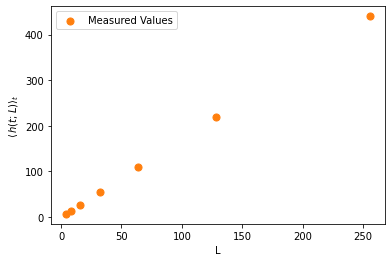

In [199]:
plt.scatter(lengths, average_height_list, s=50, marker="o",  # type: ignore
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("L")
plt.ylabel(r"$\langle \, h (t;L) \rangle_t$")
plt.show()

Which looks as expected, with the dominant scaling following $a_0 L$. 

We can remove the leading order behaviour by plotting the average height divided by $L$, in order to reveal the corrections to scaling.

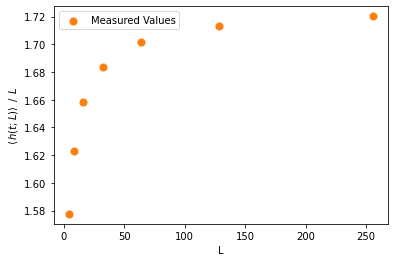

In [200]:
scaled_values = [average_height_list[i] / lengths[i]
                 for i in range(len(lengths))]

plt.scatter(lengths, scaled_values, s=50, marker="o",  # type: ignore
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("L")
plt.ylabel(r"$\langle \, h (t;L) \rangle \,\,\, / \,\,\, L$")
plt.show()


Assuming the corrections to scaling are of the form given in the instructions:

$\langle h (t;L) \rangle_t = a_0 L (1 - a_1 L^{- \omega_1})$

since we are ignoring higher order terms, we can remove the leading order behaviour to leave:

$\frac{\langle h (t;L) \rangle_t}{L} = a_0 (1 - a_1L^{-\omega_1})$

If we fit a first order polynomial to the data, we should get a value for a_0:

Fit: a0 = 1.74, a1 = 0.19, o1 = 0.49


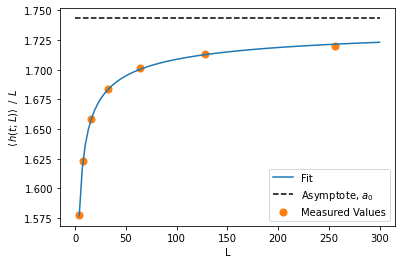

In [214]:
# fitting just a0 L, neglecting further terms
def corrections_to_scaling_func(L, a0, a1, o1):
    return a0 * (1 - a1 * L ** (-o1))


popt, pcov = curve_fit(corrections_to_scaling_func, lengths, scaled_values)
x_vals = np.linspace(4, 300, 100)
plt.plot(x_vals, corrections_to_scaling_func(x_vals, *popt),
         label="Fit", color="C0")
plt.hlines(popt[0], 0, 300, color='k',
           linestyle='dashed', label="Asymptote, $a_0$")
print("Fit: a0 = %.2f, a1 = %.2f, o1 = %.2f" % (popt[0], popt[1], popt[2]))

plt.scatter(lengths, scaled_values, s=50, marker="o",  # type: ignore
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("L")
plt.ylabel(r"$\langle \, h (t;L) \rangle \,\,\, / \,\,\, L$")
plt.show()


As a visual confirmation, this fit looks very good as well $\omega_1$ being $>0$ as required.

Note here that a_0 is the average slope for an infinite system. 

Plotting on logarithmic axes:

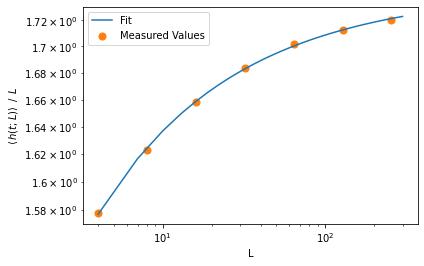

In [204]:
plt.plot(x_vals, corrections_to_scaling_func(x_vals, *popt),
         label="Fit", color="C0")
plt.scatter(lengths, scaled_values, s=50, marker="o",  # type: ignore
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("L")
plt.ylabel(r"$\langle \, h (t;L) \rangle \,\,\, / \,\,\, L$")
plt.yscale("log")
plt.xscale("log")
plt.show()

Not very interesting, and this is to be expected since taking logarithms of each side doesn't simply the equation easily. Should just put the linear plot in the report.

Fit: a0 = 1.74, a1 = 0.19, o1 = 0.50


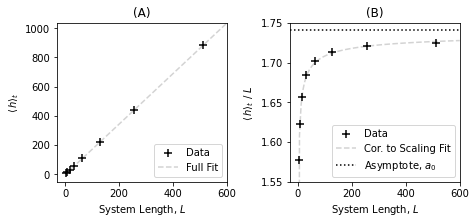

In [854]:
# figure for paper

# calculate the averages
average_height_list: list = []
for l in height_sequence_list:
    average_height_list.append(np.average(l))

# fitting


def corrections_to_scaling_func(L, a0, a1, o1):
    return a0 * (1 - a1 * L ** (-o1))


def full_scaling_func(L, a0, a1, o1):
    return a0 * L * (1 - a1 * L ** (-o1))


scaled_values = [average_height_list[i] / lengths[i]
                 for i in range(len(lengths))]

popt, pcov = curve_fit(corrections_to_scaling_func, lengths, scaled_values)
x_min, x_max = 0.1, 600
x_vals = np.linspace(x_min, x_max, 100)

# plotting
fig = plt.figure(figsize=(6.5, 3), layout="constrained")

# left
ax1 = fig.add_subplot(121)
ax1.scatter(lengths, average_height_list, s=50, marker="+", # type: ignore
            c="k", label="Data")  # type: ignore
ax1.plot(x_vals, full_scaling_func(x_vals, *popt), color='lightgrey',
         linestyle='dashed', label='Full Fit', zorder=-1)
ax1.legend(loc='lower right')
ax1.set_xlabel("System Length, $L$")
ax1.set_ylabel(r"$\langle \, h \rangle_t$")
x1, _ = ax1.get_xlim()
y1, _ = ax1.get_ylim()
ax1.set_xlim(x1, x_max)
ax1.set_ylim(y1, full_scaling_func(x_max, *popt))
ax1.set_title("(A)")

# right
ax2 = fig.add_subplot(122)
ax2.scatter(lengths, scaled_values, s=50, marker="+",  # type: ignore
            c="k", label="Data")
ax2.plot(x_vals, corrections_to_scaling_func(x_vals, *popt),
         label="Cor. to Scaling Fit", color="lightgrey", linestyle='dashed', zorder=-1)
x1, _ = ax2.get_xlim()
ax2.hlines(popt[0], x1, x_max, color='k',
           linestyle='dotted', label="Asymptote, $a_0$")
ax2.set_xlim(x1, x_max)
ax2.set_ylim(1.55, 1.75)
ax2.set_yticks([1.55, 1.60, 1.65, 1.70, 1.75])
print("Fit: a0 = %.2f, a1 = %.2f, o1 = %.2f" % (popt[0], popt[1], popt[2]))
ax2.legend()
ax2.set_xlabel("System Length, $L$")
ax2.set_ylabel(r"$\langle \, h \rangle_t \,\, / \,\, L$")
ax2.set_title("(B)")

plt.savefig('corrections_to_scaling.svg', format='svg', bbox_inches='tight')

# 2f) Standard Deviation Scaling 

How does standard deviation scale with system length - we can plot our values for standard deviation against 

In [471]:
std_values = [np.std(data) for data in height_sequence_list]

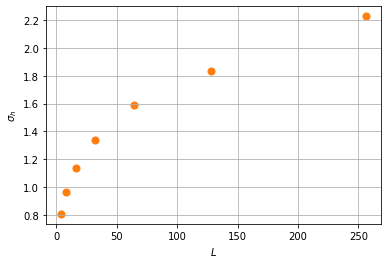

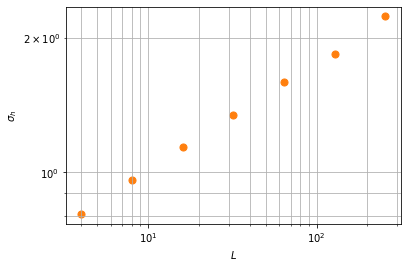

In [387]:
# linear plot
plt.scatter(lengths, std_values, s=50, marker="o",  # type: ignore
            c="C1")
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.grid()
plt.show()

# log-log plot
plt.scatter(lengths, std_values, s=50, marker="o",  # type: ignore
            c="C1")
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.yscale("log")
plt.xscale("log")
plt.grid(which='both')
plt.show()

From the logarithmic plot, the std values seem to follow a power law

Fit: a0 = 0.58, o1 = 0.24


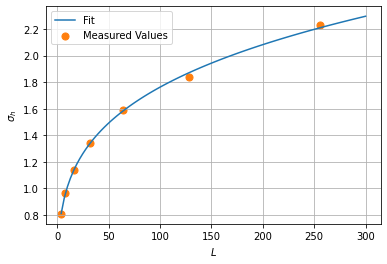

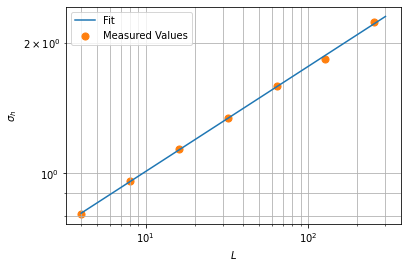

In [388]:
# of the various random functions, this seems to work best
def std_cts_func(L, a0, o1):
    return a0 * L ** o1


popt, pcov = curve_fit(std_cts_func, lengths, std_values)
x_vals = np.linspace(4, 300, 100)
print("Fit: a0 = %.2f, o1 = %.2f" % (popt[0], popt[1]))

# linear plot
plt.plot(x_vals, std_cts_func(x_vals, *popt),
         label="Fit", color="C0")
plt.scatter(lengths, std_values, s=50, marker="o",  # type: ignore
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.grid()
plt.show()

# log-log plot
plt.plot(x_vals, std_cts_func(x_vals, *popt),
         label="Fit", color="C0")
plt.scatter(lengths, std_values, s=50, marker="o",  # type: ignore
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.yscale("log")
plt.xscale("log")
plt.grid(which='both')
plt.show()

Found this fit to be: $\sigma = a_0 \, L^{\omega_1}$

Where $a_0 = 0.56$, $\omega_1 = 0.26$

Checked with Kim and this is correct, with the point being that you have an increasing precision in the measurement of the average gradient, as system size increases. So it scales less quickly than average height does ($L^{0.26}$ vs $L^1$)

### Predictions for average slope and its standard deviation in the limit of $L \to \infty$:

Average slope scales linearly in the limit of $L \to \infty$, however its standard deviation is unbounded since it also scales with a power law of $L$ and thus also tends to $\infty$ as $L \to \infty$, however the std will not grow as fast as the average gradient, since std only scales with $L^{0.26}$ wheras average slope scales with $L^1$

Therefore $\sigma_h / \langle h \rangle \to 0$ as $L \to \infty$

Fit: a0 = 0.51, o1 = 0.28


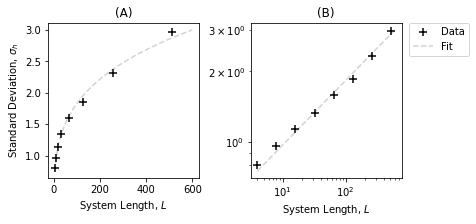

In [478]:
# plot for paper

def std_cts_func(L, a0, o1):
    return a0 * L ** o1


popt, pcov = curve_fit(std_cts_func, lengths, std_values)
x_vals = np.linspace(4, 600, 100)
print("Fit: a0 = %.2f, o1 = %.2f" % (popt[0], popt[1]))

# plot
fig = plt.figure(figsize=(6.5, 3), layout="constrained")

# linear plot
ax1 = fig.add_subplot(121)
ax1.scatter(lengths, std_values, s=50,
            marker="+", c="k", label="Data")  # type: ignore
ax1.plot(x_vals, std_cts_func(x_vals, *popt), label=r"Fit",
         color='lightgrey', linestyle='dashed', zorder=-1)
ax1.set_xlabel("System Length, $L$")
ax1.set_ylabel(r"Standard Deviation, $\sigma_h$")
ax1.set_title("(A)")

# log-log plot
ax2 = fig.add_subplot(122)
ax2.scatter(lengths, std_values, s=50,
            marker="+", c="k", label="Data")  # type: ignore
ax2.plot(x_vals, std_cts_func(x_vals, *popt), label="Fit",
         color='lightgrey', linestyle='dashed', zorder=-1)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax2.set_xlabel("System Length, $L$")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("(B)")

plt.savefig('standard_deviation.svg', format='svg', bbox_inches='tight')

# 2g) The Height Probability Distribution

## i) Theoretical prediction 
If each individual gradient was independent of every other gradient then by the central limit theorem, we would expect the height probability distribution to be a symmetrical Gaussian about the average. In this scenario the std would follow the standard error formula, and thus would decrease with the square root of the number of sites.

### Scaling of $P(h;L)$

Therefore we'd expect $P(h;L)$ to scale as:

$$P(h;L) = \frac{1}{\sigma_h(L) \sqrt{2 \pi}} \exp\Bigg({-\frac{1}{2} \Big(\frac{h(L)-\langle h(L) \rangle}{\sigma_h(L)}} \Big)^2 \Bigg)$$

### Scaling of $\sigma(L)$ with $L$

where, according to the central limit theorem

$$\sigma_h(L) = \frac{\sigma}{\sqrt{n}} = \frac{\sigma}{\sqrt{L}}$$

since 

$$h = \sum_{i=1}^L z_i$$

and so we have $L$ independent variables over which we're summing, so $n = L$.

## ii) Plotting and Data Collapse

Plotting all of the height probability distributions individually:

### Plotting all data on one graph

This should be consistently decreasing, since standard deviation is increasing and we are claiming it to be similar to a Gaussian, so peak should decrease with increasing height (according to Kim)

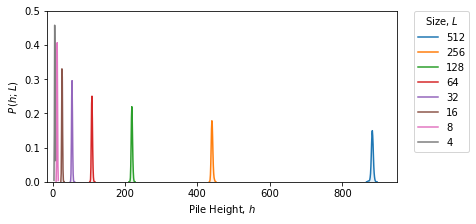

In [507]:
fig = plt.figure(figsize=(6.5, 3), layout="constrained")

ax1 = fig.add_subplot(111)
for i in reversed(range(len(lengths))):
    data = height_sequence_list[i]
    n, bins, patches = plt.hist(data, max(data) - min(data) + 1, density=True,
                                range=(min(data)-0.5, max(data)+0.5), alpha=0.1)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
    ax1.plot(bin_means, n, color="C%i" %
             (len(lengths) - i - 1), label=lengths[i])
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
           borderaxespad=0., title="Size, $L$")
ax1.set_xlabel("Pile Height, $h$")
ax1.set_xlim(-15, 950)
ax1.set_ylim(0, 0.5)
ax1.set_ylabel("$P \, (h;L)$")

plt.savefig('all_prob_distributions.svg', format='svg', bbox_inches='tight')

### Data Collapse

Formula for a Gaussian is:
$$P(h;L) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\Bigg({-\frac{1}{2} \Big(\frac{h-\langle h \rangle}{\sigma}} \Big)^2 \Bigg)$$

We can do a similar approach to the finite scaling ansatz and collapse this by plotting:

$$\sigma_h P(h;L) = \mathcal{G}\bigg(\frac{h - \langle h \rangle}{\sigma_h}\bigg) = \frac{1}{\sqrt{2 \pi}} \exp(-\frac{1}{2}x^2)$$

Therefore, plotting $\sigma_h P(h;L)$ against $\frac{h - \langle h \rangle}{\sigma_h}$ should lead to a data collapse where all Gaussian functions will collapse to a single Gaussian with mean 0 and std 1. 

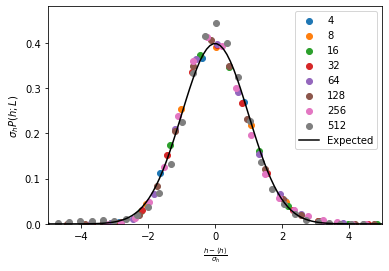

In [512]:
def collapse_func(x):
    return (1 / np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)

for i in range(len(lengths)):
    data = height_sequence_list[i]
    average = np.average(data)
    std = np.std(data)

    n, bins, patches = plt.hist(data, max(data) - min(data) + 1, density=True,
                                range=(min(data)-0.5, max(data)+0.5), alpha=0)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

    scaled_n = np.array(n)*std
    scaled_bin_means = [(bin_mean - average)/std for bin_mean in bin_means]
    plt.scatter(scaled_bin_means, scaled_n, color="C%s" % i, label=lengths[i])

x_vals = np.linspace(-5, 5, 100)
plt.plot(x_vals, collapse_func(x_vals), color='k', label='Expected')

plt.legend()
plt.ylabel(r"$\sigma_h P(h;L)$")
plt.xlabel(r"$\frac{h - \langle h \rangle}{\sigma_h}$")
plt.xlim(-5, 5)
plt.show()

This is what we'd expect (confirmed by demonstrator).

First plotting the difference between the two graphs:

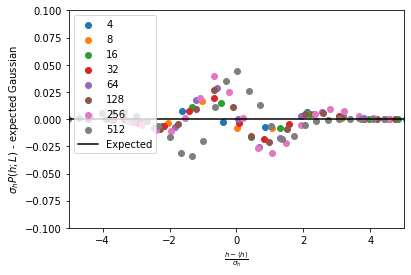

In [510]:
def collapse_func(x) -> float:
    return (1 / np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)


for i in range(len(lengths)):
    data = height_sequence_list[i]
    average = np.average(data)
    std = np.std(data)

    n, bins, patches = plt.hist(data, max(data) - min(data) + 1, density=True,
                                range=(min(data)-0.5, max(data)+0.5), alpha=0)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

    # scaling the data in order for it to collapse
    scaled_n = np.array(n)*std
    scaled_bin_means = [(bin_mean - average)/std for bin_mean in bin_means]

    diff_n = []
    # subtracting the expected values
    for index in range(len(scaled_n)):
        diff_n.append(scaled_n[index] - collapse_func(scaled_bin_means[index]))

    plt.scatter(scaled_bin_means, diff_n, color="C%s" % i, label=lengths[i])

x_vals = np.linspace(-5, 5, 100)
plt.plot(x_vals, [0 for i in x_vals], color='k', label='Expected')

plt.legend()
plt.ylabel(r"$\sigma_h P(h;L)$ - expected Gaussian")
plt.xlabel(r"$\frac{h - \langle h \rangle}{\sigma_h}$")
plt.xlim(-5, 5)
plt.ylim(-0.1, 0.1)
plt.show()

Now plotting the difference, divided by the expected Gaussian so giving the fractional difference between the two.

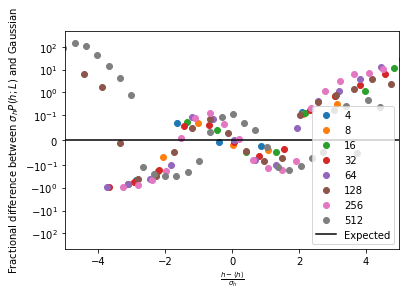

In [509]:
def collapse_func(x) -> float:
    return (1 / np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)


for i in range(len(lengths)):
    data = height_sequence_list[i]
    average = np.average(data)
    std = np.std(data)

    n, bins, patches = plt.hist(data, max(data) - min(data) + 1, density=True,
                                range=(min(data)-0.5, max(data)+0.5), alpha=0)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

    # scaling the data in order for it to collapse
    scaled_n = np.array(n)*std
    scaled_bin_means = [(bin_mean - average)/std for bin_mean in bin_means]

    diff_n = []
    # subtracting the expected values
    for index in range(len(scaled_n)):
        diff_n.append(
            (scaled_n[index] / collapse_func(scaled_bin_means[index]))-1)

    plt.scatter(scaled_bin_means, diff_n, color="C%s" % i, label=lengths[i])

x_vals = np.linspace(-5, 5, 100)
plt.plot(x_vals, [0 for i in x_vals], color='k', label='Expected')

plt.legend()
plt.ylabel(r"Fractional difference between $\sigma_h P(h;L)$ and Gaussian")
plt.xlabel(r"$\frac{h - \langle h \rangle}{\sigma_h}$")
plt.xlim(-5, 5)
plt.ylim(-500, 500)
plt.yscale("symlog", linthresh=0.1)
plt.show()

This allows us to see that the tails of the distribution definitely do not follow a Gaussian, with the positive tail being particularly skewed. Note the Symlog scale to show negative values (symlog being symmetrical log with a linear region around zero, which should be clearly defined if I put this in the report)

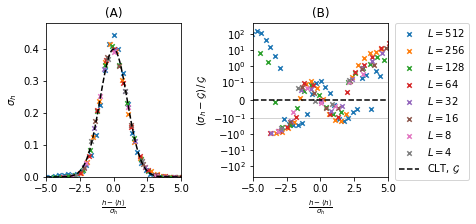

In [532]:
# plot for paper 

def collapse_func(x):
    return (1 / np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
x_min, x_max = -5, 5
x_vals = np.linspace(x_min, x_max, 100)

fig = plt.figure(figsize=(6.5, 3), layout="constrained")

# linear plot
ax1 = fig.add_subplot(121)
for i in reversed(range(len(lengths))):
    data = height_sequence_list[i]
    average = np.average(data)
    std = np.std(data)
    n, bins, patches = plt.hist(data, max(data) - min(data) + 1, density=True,
                                range=(min(data)-0.5, max(data)+0.5), alpha=0)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
    scaled_n = np.array(n)*std
    scaled_bin_means = [(bin_mean - average)/std for bin_mean in bin_means]
    ax1.scatter(scaled_bin_means, scaled_n, s=20, color="C%i" % (len(lengths) - i - 1), label="$L=$%i" % lengths[i], marker="x") # type: ignore
ax1.plot(x_vals, collapse_func(x_vals), color='k', label='CLT', linestyle='dashed')
ax1.set_xlabel(r"$\frac{h - \langle h \rangle}{\sigma_h}$")
ax1.set_ylabel(r"$\sigma_h$")
ax1.set_xlim(x_min, x_max)
ax1.set_title("(A)")

# log-log plot
ax2 = fig.add_subplot(122)
for i in reversed(range(len(lengths))):
    data = height_sequence_list[i]
    average = np.average(data)
    std = np.std(data)
    n, bins, patches = plt.hist(data, max(data) - min(data) + 1, density=True,
                                range=(min(data)-0.5, max(data)+0.5), alpha=0)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
    scaled_n = np.array(n)*std
    scaled_bin_means = [(bin_mean - average)/std for bin_mean in bin_means]
    diff_n = []
    # subtracting the expected values
    for index in range(len(scaled_n)):
        diff_n.append(
            (scaled_n[index] / collapse_func(scaled_bin_means[index]))-1)
    ax2.scatter(scaled_bin_means, diff_n, s=20, color="C%i" % (len(lengths) - i - 1), label="$L=$%i" % lengths[i], marker="x") # type: ignore

ax2.plot(x_vals, [0 for i in x_vals], color='k', label="CLT, $\mathcal{G}$", linestyle='dashed')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax2.set_xlabel("System Length, $L$")
ax2.set_ylabel(r"$(\sigma_h - \mathcal{G}) \, / \, \mathcal{G}$")
ax2.set_xlabel(r"$\frac{h - \langle h \rangle}{\sigma_h}$")
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(-500, 500)
ax2.set_yscale("symlog", linthresh=0.1)
ax2.hlines([0.1, -0.1], x_min, x_max, color='lightgrey', linewidth=1, zorder=-1)
ax2.set_title("(B)")

plt.savefig('gaussian_data_collapse.svg', format='svg', bbox_inches='tight')


## iii) Numerical test 

Show the difference plot here, commenting that the distributions are skewed slightly. 

Show and back up that this isn't a Gaussian, with the data.

Crux is that they're not independent, so the assumption is broken.

Apparently a numerical test may be changing the way we sample, eg. sampling randomly.

Eg. gradient correlation between $z_i$ and $z_{i+1}$. It says not "necessarily" implementing teh numerical test, so presumably it will look good to implement the test. 

#### Numerical Test of Site Independence

If each gradient were random, there should be no correlation between site $i$ and $i+1$. This means if we scatter plot all the gradients at site $i$ (0, 1, 2) against all those at site $i+1$ there should be zero correlation. 

One point to note is that dependence between states doesn't infer the states should be causing nearby states to have the same gradient as them, it just means their gradient value should be non-random. Eg. it might make the gradient of site $i+1$ less likely to be equal to that of site $i$. 

In [81]:
# data generation
length = 512
cycles_after_transient = 1000

model = Model(length)
while model.get_is_transient():
    model.cycle()
for _ in range(cycles_after_transient):
    model.cycle()
gradients = model.get_gradients()

[[1. 1.]
 [1. 1.]]
Correlation between y and x is 1.000


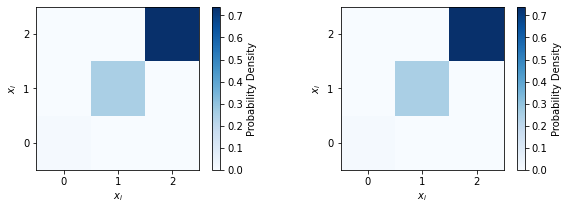

In [82]:
# if we plot the gradients against itself, then we should get perfect correlation
x = gradients
y = gradients

r = np.corrcoef(x, y)
print(r)
print("Correlation between y and x is %.3f" % r[0][1])

# plt.scatter(gradients, gradients)
# plt.xlabel("$z_i$")
# plt.ylabel("$z_i$")

edges = [-0.5, 0.5, 1.5, 2.5]
H, np_xedges, np_yedges = np.histogram2d(
    x, y, bins=(edges, edges), density=True)  # type: ignore
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(10, 3))

ax1 = fig.add_subplot(121)
X, Y = np.meshgrid(edges, edges)
im = ax1.pcolormesh(X, Y, H, cmap='Blues')
plt.colorbar(im, label="Probability Density")
ax1.set_xlabel("$x_i$")
ax1.set_ylabel("$x_i$")
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(-0.5, 2.5)
ax1.set_xticks([0, 1, 2])
ax1.set_yticks([0, 1, 2])

ax2 = fig.add_subplot(122)
X, Y = np.meshgrid(edges, edges)
im = ax2.pcolormesh(X, Y, H, cmap='Blues')
plt.colorbar(im, label="Probability Density")
ax2.set_xlabel("$x_i$")
ax2.set_ylabel("$x_i$")
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(-0.5, 2.5)
ax2.set_xticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])

plt.show()

[[ 1.         -0.13489529]
 [-0.13489529  1.        ]]
Correlation between y and x is -0.135


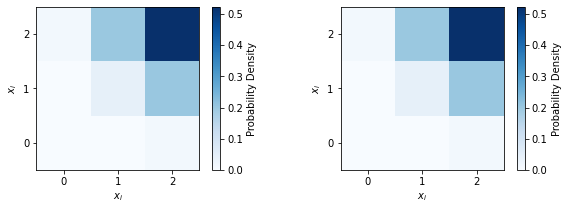

In [87]:
# now if we shift x to be x+1, we compared adjacent sites
y = gradients[0:len(gradients)-1]
x = gradients[1:len(gradients)]

r = np.corrcoef(x, y)
print(r)
print("Correlation between y and x is %.3f" % r[0][1])

edges = [-0.5, 0.5, 1.5, 2.5]
H, np_xedges, np_yedges = np.histogram2d(
    x, y, bins=(edges, edges), density=True)  # type: ignore
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(10, 3))

ax1 = fig.add_subplot(121)
X, Y = np.meshgrid(edges, edges)
im = ax1.pcolormesh(X, Y, H, cmap='Blues')
plt.colorbar(im, label="Probability Density")
ax1.set_xlabel("$x_i$")
ax1.set_ylabel("$x_i$")
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(-0.5, 2.5)
ax1.set_xticks([0, 1, 2])
ax1.set_yticks([0, 1, 2])

ax2 = fig.add_subplot(122)
X, Y = np.meshgrid(edges, edges)
im = ax2.pcolormesh(X, Y, H, cmap='Blues')
plt.colorbar(im, label="Probability Density")
ax2.set_xlabel("$x_i$")
ax2.set_ylabel("$x_i$")
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(-0.5, 2.5)
ax2.set_xticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])

plt.show()

In [94]:
counts = {
    0: 0,
    1: 0,
    2: 0
}

for i in gradients:
    counts[i] += 1

probs = {}
for i in counts.keys():
    probs[i] = counts[i] / sum(counts.values())

print("Counts:", counts)
print("Probs:", probs)

Counts: {0: 7, 1: 127, 2: 378}
Probs: {0: 0.013671875, 1: 0.248046875, 2: 0.73828125}


[[ 1.         -0.00448451]
 [-0.00448451  1.        ]]
Correlation between y and x is -0.004


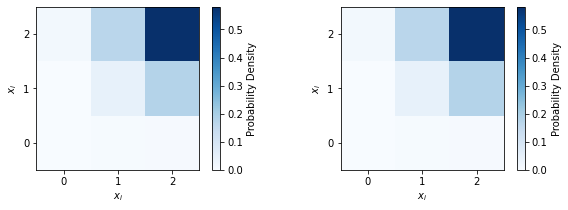

In [153]:
# We can now simulate what the heights would be if they were random, according to the same probability distribution
def get_num():
    return np.random.choice([0, 1, 2], p=[0.013671875, 0.248046875, 0.73828125])


x = [get_num() for i in range(len(gradients))]
y = [get_num() for i in range(len(gradients))]

r = np.corrcoef(x, y)
print(r)
print("Correlation between y and x is %.3f" % r[0][1])

edges = [-0.5, 0.5, 1.5, 2.5]
H, np_xedges, np_yedges = np.histogram2d(
    x, y, bins=(edges, edges), density=True)  # type: ignore
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(10, 3))

ax1 = fig.add_subplot(121)
X, Y = np.meshgrid(edges, edges)
im = ax1.pcolormesh(X, Y, H, cmap='Blues')
plt.colorbar(im, label="Probability Density")
ax1.set_xlabel("$x_i$")
ax1.set_ylabel("$x_i$")
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(-0.5, 2.5)
ax1.set_xticks([0, 1, 2])
ax1.set_yticks([0, 1, 2])

ax2 = fig.add_subplot(122)
X, Y = np.meshgrid(edges, edges)
im = ax2.pcolormesh(X, Y, H, cmap='Blues')
plt.colorbar(im, label="Probability Density")
ax2.set_xlabel("$x_i$")
ax2.set_ylabel("$x_i$")
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(-0.5, 2.5)
ax2.set_xticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])

plt.show()

These plots don't really show anything so I won't include them, but they're interesting to sanity check the results. A better plot would be showing how the correlation changes with distance.

In [753]:
length = 512
repetitions = 10
cycles_after_transient = 1000
filename = 'gaussian_gradients.pickle'

In [754]:
gradients = []

for rep in range(repetitions):
    # initiate model
    model = Model(length)
    # run model
    while model.get_is_transient():
        model.cycle()
    for _ in range(cycles_after_transient):
        model.cycle()
    # get gradients
    gradients.append(model.get_gradients())
    print("Rep", rep + 1, "of", repetitions, "complete")

# saving
with open(filename, "wb") as f:
  pickle.dump(gradients, f)

Rep 1 of 10 complete
Rep 2 of 10 complete
Rep 3 of 10 complete
Rep 4 of 10 complete
Rep 5 of 10 complete
Rep 6 of 10 complete
Rep 7 of 10 complete
Rep 8 of 10 complete
Rep 9 of 10 complete
Rep 10 of 10 complete


In [549]:
# reload saved 
with open(filename, "rb") as f:
  gradients = pickle.load(f)

In [758]:
# calculate the correlations
separations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

correlations = {}
for s in separations:
    correlations[s] = []

for rep in range(len(gradients)):
    single_grad_list = gradients[rep]

    # measure the correlations
    for s in separations:
        # create the two arrays for correlation
        y = single_grad_list[0:len(single_grad_list)-s]
        x = single_grad_list[s:len(single_grad_list)]
        # find the correlation coefficient
        corr = np.corrcoef(x, y)[0][1]
        # save the correlation
        correlations[s].append(corr)

correlation_means = []
errors = []

# extract the mean and std
for s in separations:
    correlation_means.append(np.mean(correlations[s]))
    errors.append(np.std(correlations[s]))

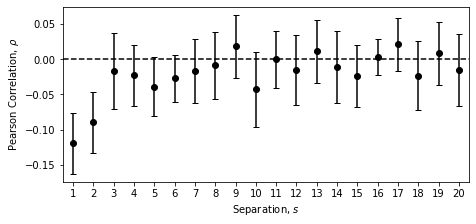

In [759]:
fig = plt.figure(figsize=(6.5, 3), layout="constrained")

ax1 = fig.add_subplot(111)
ax1.errorbar(separations, correlation_means, yerr=errors, fmt='o', capsize=3, c='k')
ax1.set_xlabel("Separation, $s$")
ax1.set_ylabel(r"Pearson Correlation, $\rho$")
ax1.set_xticks(separations)
ax1.hlines([0], [separations[0] - 0.5],
           [separations[-1] + 0.5], color='k', linestyle='dashed')
ax1.set_xlim(separations[0] - 0.5, separations[-1] + 0.5)

plt.savefig('correlations.svg', format='svg', bbox_inches='tight')

In [231]:
print("Means:", correlation_means)
print("Errors:", errors)

# for L = 512, n = 5 repetitions
# Means: [-0.1514811420727015, -0.07113885468267422, -0.041081558518249996, -0.03652033078293462, -0.0201698536347503]
# Errors: [0.01698933752084618, 0.04462240694033981, 0.0129137651372497, 0.016071116084298523, 0.01890180728987847]

# for L = 1024, n = 5 repetitions
# Means: [-0.13087528649960453, -0.06371836080683105, -0.055264267048188945, -0.05027214655660626, -0.012643800499601574]
# Errors: [0.02898622062117793, 0.02608531259839334, 0.02751658564328225, 0.013395638116773231, 0.03035874177935761]

Means: [-0.13087528649960453, -0.06371836080683105, -0.055264267048188945, -0.05027214655660626, -0.012643800499601574]
Errors: [0.02898622062117793, 0.02608531259839334, 0.02751658564328225, 0.013395638116773231, 0.03035874177935761]


# 3a) Avalanches

Plotting the time series of avalanche size

Remember to comment that care was taken to ensure no values approached the 32 bit integer limit in order to prevent issues with numpy 32 bit integers not being able to store the largest avalanches.

In [760]:
lengths = [4, 8, 16, 32, 64, 128, 256]
num_cycles = 50000
repetitions = 2
filename = 'avalanches_list.pickle'

In [761]:
avalanches_list: list[list[int]] = []

for length in lengths:
    avalanches: list[int] = []

    for _ in range(repetitions):
        model = Model(length)
        # get the model to steady state
        while model.get_is_transient():
            model.cycle()
        # only then count the avalanches
        for i in range(num_cycles):
            avalanches.append(model.cycle_with_relax_count())
    
    avalanches_list.append(avalanches)
    print(length, 'complete')

# saving
with open(filename, "wb") as f:
  pickle.dump(avalanches_list, f)

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


In [565]:
# reload saved avalanches
with open(filename, "rb") as f:
  avalanches_list: list[list[int]] = pickle.load(f)

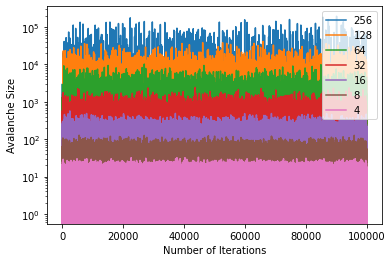

In [762]:
# linear plot of the raw data
for i in reversed(range(len(lengths))):
    plt.plot(range(len(avalanches_list[i])),
             avalanches_list[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Avalanche Size")
plt.yscale('log')
plt.show()

In [763]:
# checking that the "avalanche size 0" cycles are being recorded
counts = {}
for i in np.sort(avalanches_list[0]):
    try:
        counts[i] += 1
    except:
        counts[i] = 1
print(counts)
print("Number of avalanches size 0:", counts[0])

{0: 35781, 1: 17235, 2: 6384, 3: 3725, 4: 5602, 5: 2820, 6: 3063, 7: 2913, 8: 4148, 9: 2062, 10: 1989, 11: 3103, 12: 1296, 13: 2063, 14: 1437, 15: 1528, 16: 590, 17: 1275, 18: 873, 19: 278, 20: 605, 21: 436, 22: 236, 23: 106, 24: 226, 25: 110, 26: 32, 27: 40, 28: 12, 29: 14, 30: 11, 31: 3, 32: 3, 33: 1}
Number of avalanches size 0: 35781


## i) Plotting log-binned probabilities

In [764]:
# calculate the probabilities
probs_list = []

for l in range(len(lengths)):
    probs = {}
    for i in np.sort(avalanches_list[l]):
        try:
            probs[i] += 1/num_cycles
        except:
            probs[i] = 1/num_cycles
    probs_list.append(probs)

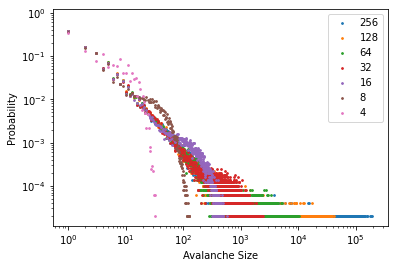

In [765]:
# plotting the non-binned probabilities
for l in reversed(range(len(lengths))):
    plt.scatter(probs_list[l].keys(),
                probs_list[l].values(), s=3, label=str(lengths[l]))
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Avalanche Size')
plt.ylabel('Probability')
plt.show()

In [766]:
# note I went for a scale of 1.1, since that looked the best and is also used in the lecture notes in the data collapse section
log_binned_avalanches_x = []
log_binned_avalanches_y = []
scale = 1.1
for i in avalanches_list:
    x_vals, y_vals = logbin(i, scale=scale, zeros=False)
    log_binned_avalanches_x.append(x_vals)
    log_binned_avalanches_y.append(y_vals)

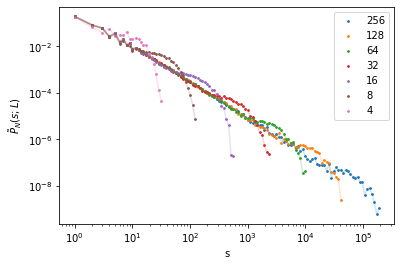

In [767]:
for i in reversed(range(len(lengths))):
    plt.scatter(
        log_binned_avalanches_x[i], log_binned_avalanches_y[i], s=3, label=str(lengths[i]))
    plt.plot(log_binned_avalanches_x[i], log_binned_avalanches_y[i], alpha=0.2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('s')
plt.ylabel(r'$\tilde{P}_N(s;L)$')
plt.show()

Describing qualitatively the results, we can see very similar results to what was expected. We see a scale invariant distribution of avalanche size probability throughout the scaling region, followed by a system size dependent cut-off. Avalanches are found across many orders of magnitude, and smaller avalanches are more likely than larger ones.

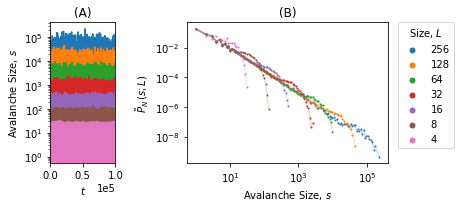

In [608]:
# plot for paper 

fig = plt.figure(figsize=(6.5, 3), tight_layout=True)
gs = gridspec.GridSpec(1, 3)

# log-linear plot of raw data
ax1 = fig.add_subplot(gs[0, 0])
for i in reversed(range(len(lengths))):
    ax1.plot(range(len(avalanches_list[i])),
             avalanches_list[i], label=str(lengths[i]), rasterized=True)
ax1.set_xlabel("$t$")
ax1.set_ylabel("Avalanche Size, $s$")
ax1.set_yscale('log')
ax1.set_xticks([0, 50000, 100000])
ax1.set_xlim(0, 100000)
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
ax1.set_title("(A)")

ax2 = fig.add_subplot(gs[0, 1:])
for i in reversed(range(len(lengths))):
    ax2.scatter(
        log_binned_avalanches_x[i], log_binned_avalanches_y[i], s=1, label=str(lengths[i]))
    ax2.plot(log_binned_avalanches_x[i], log_binned_avalanches_y[i], alpha=0.2, rasterized=True)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel("Avalanche Size, $s$")
ax2.set_ylabel(r'$\tilde{P}_N \,(s;L)$')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=5, title=r"Size, $L$")
ax2.set_title("(B)")

plt.savefig('avalanche_probs.svg', format='svg', bbox_inches='tight', dpi=300)

## ii) Applying the finite-size scaling ansatz

This is given as:
$$\begin{align}\tilde{P}_N(s;L) &\propto s^{-\tau_s} \mathcal{G}(s / L^D) &\text{for } L \gg 1, s \gg 1 \nonumber\end{align}$$

Rearranging to align the peaks, we can plot:
$$s^{\tau_s} \tilde{P}(s;L) \propto \mathcal{G} (s / L^D)$$

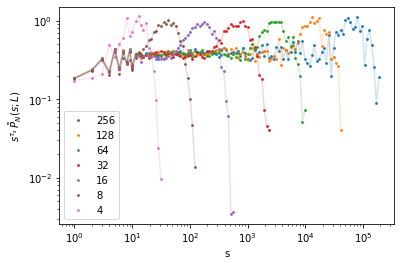

In [811]:
# multiplying each of the the y values by s^tau
tau_s = 1.56
scaled_avalanches_y = []
for i in range(len(log_binned_avalanches_y)):
    scaled_avalanche = []
    for j in range(len(log_binned_avalanches_y[i])):
        scaled_avalanche.append(
            log_binned_avalanches_y[i][j] * log_binned_avalanches_x[i][j]**(tau_s))
    scaled_avalanches_y.append(scaled_avalanche)

for i in reversed(range(len(lengths))):
    plt.scatter(
        log_binned_avalanches_x[i], scaled_avalanches_y[i], s=3, label=str(lengths[i]))
    plt.plot(log_binned_avalanches_x[i], scaled_avalanches_y[i], alpha=0.2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('s')
plt.ylabel(r'$s^{\tau_s} \, \tilde{P}_N(s;L)$')
plt.show()

The peaks of the "bumps" seem to line up for $\tau_s \sim 1.55$. We can now perform the data collapse by plotting $s/L^D$ on the x axis and optimising $D$:

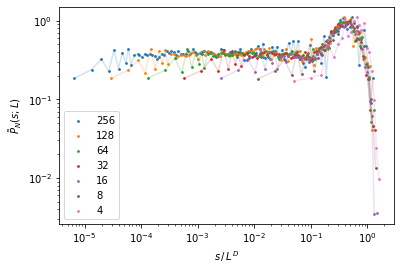

In [806]:
# dividing each of the the x values by L^D
D =2.15
scaled_avalanches_x = []
for i in range(len(log_binned_avalanches_x)):
    scaled_avalanches_x.append(log_binned_avalanches_x[i] / (lengths[i]**D))

for i in reversed(range(len(lengths))):
    plt.scatter(
        scaled_avalanches_x[i], scaled_avalanches_y[i], s=3, label=str(lengths[i]))
    plt.plot(scaled_avalanches_x[i], scaled_avalanches_y[i], alpha=0.2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$s \, / \, L^D$')
plt.ylabel(r'$\tilde{P}_N(s;L)$')
plt.show()

The data does indeed collapse, with an avalanche dimension $D \sim 2.15$ which is expected since the notes give a value of 2.25

It may be possible to get a much better data collapse with repetitions and more data points, at which point it may be possible to get to 2.25

Note that it's fine to do this by eye, according to the demonstrators

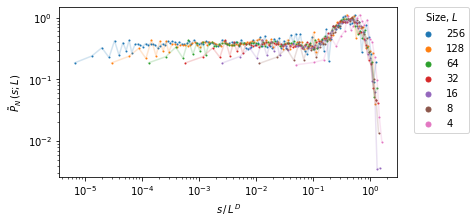

In [807]:
# plot for paper

fig = plt.figure(figsize=(6.5, 3), layout="constrained")

ax1 = fig.add_subplot(111)
for i in reversed(range(len(lengths))):
    ax1.scatter(
        scaled_avalanches_x[i], scaled_avalanches_y[i], s=1, label=str(lengths[i]))
    ax1.plot(scaled_avalanches_x[i], scaled_avalanches_y[i], alpha=0.2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'$s \, / \, L^D$')
ax1.set_ylabel(r'$\tilde{P}_N \, (s;L)$')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=5, title=r"Size, $L$")

plt.savefig('avalanche_collapse.svg', format='svg', bbox_inches='tight')

# 3b) Avalanche Moments

In [812]:
def calculate_moment(data, order):
    scaled_data = [i**order for i in data]
    return sum(scaled_data) / len(data)

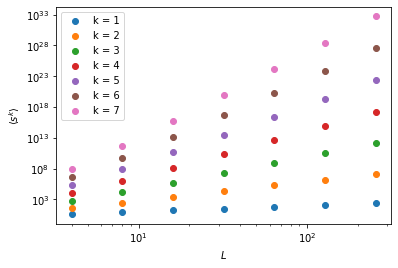

In [813]:
moments = [1, 2, 3, 4, 5, 6, 7]

# plotting
for m in moments:
    y_vals = []
    for l in range(len(lengths)):
        y_vals.append(calculate_moment(avalanches_list[l], m))
    plt.scatter(lengths, y_vals, c="C%s" % (m-1), label="k = %s" % m)

plt.xlabel("$L$")
plt.ylabel(r"$\langle s^k \rangle$")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

From the derivation in the lectures, we know that we can find $D$ and $\tau_s$ from the scaling relation of the moments:
$$\begin{align}
\langle s^k \rangle &\propto L^{D(1 + k - \tau_s)} \\
\therefore \log \langle s^k \rangle &= D(1 + k - \tau_s) \log L + \log (\text{constant})
\end{align}$$

Therefore, if we fit the scaling behaviours of the moments, we can can then plot them against $k$:

[array([1.0239815 , 0.99415448]), array([0.26404387, 3.22003677]), array([0.09399828, 5.47603563]), array([0.03953013, 7.73658932]), array([ 0.01839469, 10.00110698]), array([9.07698373e-03, 1.22706002e+01]), array([4.61269057e-03, 1.45461292e+01]), array([2.37138756e-03, 1.68280781e+01]), array([1.22260986e-03, 1.91160463e+01]), array([6.30046987e-04, 2.14091866e+01])]


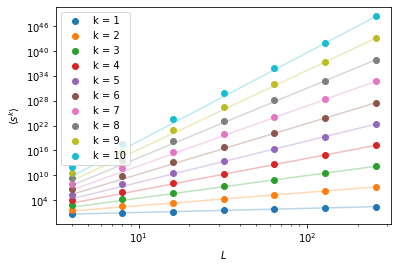

In [817]:
all_moments = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# moments you wish to plot - useful for finding initial guesses one at a time
moments = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# calculate the moments
moments_values = []
for m in moments:
    y_vals = []
    for l in range(len(lengths)):
        y_vals.append(calculate_moment(avalanches_list[l], m))
    moments_values.append(y_vals)

def power_law_func(L, a0, a1):
    try:
        L[0]
        results = []
        for L_i in L:
            results.append(a0 * L_i ** a1)
        return results
    except:
        return a0 * L ** a1

fit_data = []
initial_guesses = [
    [1, 1],     #1
    [0.2, 3.2],     #2
    [0.1, 5],   #3
    [0.01, 8],   #4
    [0.01, 10],  #5
    [0.001, 12.4],  #6
    [0.001, 14.8],  #7
    [0.0001, 17.2],    #8
    [0.0001, 19.7],    #9
    [0.00001, 22]     #10
]
for m in range(len(moments)):
    popt, pcov = curve_fit(power_law_func, lengths,
                           moments_values[m], p0=initial_guesses[all_moments.index(moments[m])], method='dogbox', max_nfev=100000)
    fit_data.append(popt)
print(fit_data)

# plotting
fit_x_vals = np.linspace(4, 256, 1000)
for m in range(len(moments)):
    plt.scatter(lengths, moments_values[m], c="C%s" % (
        m), label="k = %s" % (moments[m]))
    plt.plot(fit_x_vals, power_law_func(
        fit_x_vals, *fit_data[m]), color="C%s" % (m), alpha=0.3)
plt.xlabel("$L$")
plt.ylabel(r"$\langle s^k \rangle$")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

Now we have the data from the fits, we can plot it against moment number:

Fit: -1.32 + 2.27 * k


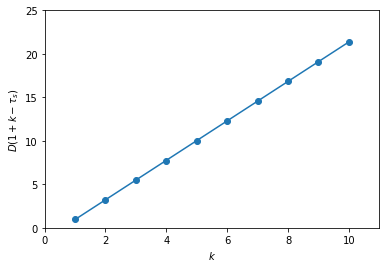

In [830]:
# extract the value
y_vals = [i[1] for i in fit_data]
x_vals = moments

# y_vals = [i[1] for i in fit_data][0:3]
# x_vals = moments[0:3]

# fit a straight line to the data

def linear_func(k, a, b):
    try:
        k[0]
        results = []
        for k_i in k:
            results.append(a + b*k_i)
        return results
    except:
        return a + b*k

popt, pcov = curve_fit(linear_func, x_vals, y_vals)
print("Fit: %.2f + %.2f * k" % (popt[0], popt[1]))

# plotting
plt.scatter(x_vals, y_vals)
plt.plot(x_vals, linear_func(x_vals, popt[0], popt[1]))
plt.xlabel("$k$")
plt.xlim(0, 11)
plt.ylim(0, 25)
plt.ylabel(r"$D(1 + k - \tau_s)$")
plt.show()

In [831]:
D = popt[1]
Ts = 1 - (popt[0]/popt[1])
print("D: %.3f" % D)
print("Ts: %.3f" % Ts)

D: 2.269
Ts: 1.583


In [ ]:
D = popt[1]
Ts = 1 - (popt[0]/popt[1])
print("D: %.3f" % D)
print("Ts: %.3f" % Ts)

D: 2.269
Ts: 1.583


This gives $D = 2.16$ which is very similar to what we got before, and from the y intercept (y_0) we can find $\tau_s$ from:
$$y_0 = D (1 - \tau_s)$$
$$\therefore \tau_s = 1 - \frac{y0}{D}  = 1 + \frac{1.05}{2.16} = 1.48$$

Which is very close to our previous value of 1.55

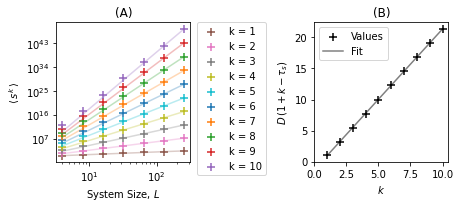

In [825]:
# plot for paper
fig = plt.figure(figsize=(6.5, 3), tight_layout=True)
color_shift = 5

ax1 = fig.add_subplot(121)
for m in range(len(moments)):
    ax1.scatter(lengths, moments_values[m], c="C%s" % (
        m + color_shift), label="k = %s" % (moments[m]), marker='+', s=50) # type: ignore
    ax1.plot(lengths, power_law_func(
        lengths, *fit_data[m]), color="C%s" % (m + color_shift), alpha=0.3)
ax1.set_xlabel("System Size, $L$")
ax1.set_ylabel(r"$\langle \, s^k \, \rangle$")
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax1.set_title("(A)")

ax2 = fig.add_subplot(122)
ax2.scatter(x_vals, y_vals, c='k', label='Values', marker='+', s=50)
ax2.plot(x_vals, linear_func(x_vals, popt[0], popt[1]), c='grey', zorder=-1, label='Fit')
ax2.set_xlabel("$k$")
ax2.set_ylabel(r"$D \, (1 + k - \tau_s)$")
ax2.set_xticks([0, 2.5, 5, 7.5, 10])
ax2.legend()
ax2.set_title("(B)")

plt.savefig('moments.svg', format='svg', bbox_inches='tight')